In [333]:
import sys
import os
# sys.path.append(os.path.abspath("..")) 
import importlib
# import src

In [334]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.cm as cm


import math
from IPython.display import display
import yfinance as yf

import matplotlib.pyplot as plt


In [335]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [336]:
import pandas_datareader.data as web
import yfinance as yf
from datetime import datetime

In [337]:
trainval_start = "2006-04-02"
trainval_end = "2019-12-31"
test_start = "2020-01-01"
# test_start = "2020-01-01"
test_end = "2022-12-31"

trainval_end = (pd.to_datetime(trainval_end) - pd.tseries.offsets.BDay(53)).strftime("%Y-%m-%d")
test_start = (pd.to_datetime(test_start) - pd.tseries.offsets.BDay(53)).strftime("%Y-%m-%d")

In [338]:
etfs = ['AGG', 'DBC', 'VTI']
asset_names = etfs + ["VIX"]
n_assets = len(asset_names)
vix = web.DataReader('VIXCLS', 'fred',  start=trainval_start, end=test_end)
close_df = yf.download(etfs, start=trainval_start, end=test_end)["Close"]
close_df["VIX"] = vix

returns_df =  close_df.pct_change()[1:]
close_df = close_df[1:]

[*********************100%***********************]  3 of 3 completed


/tmp/ipykernel_395219/1499455753.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


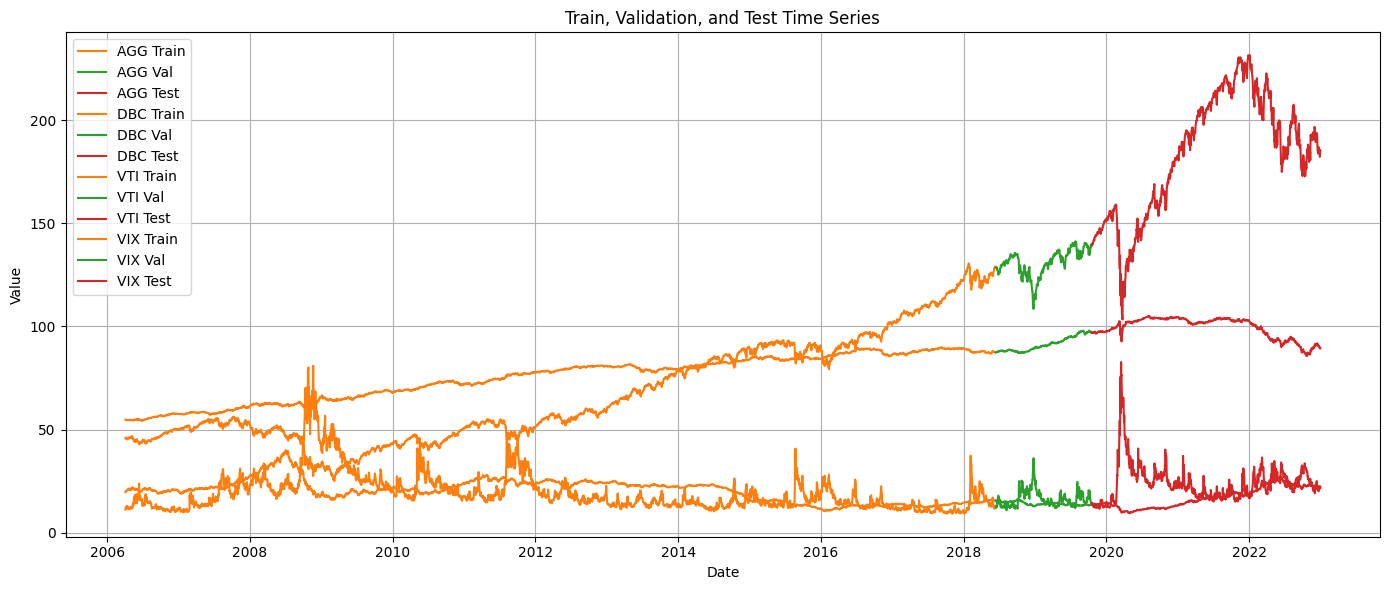

In [ ]:
# df = returns_df

colors = cm.get_cmap('tab10')


trainval_mask = (close_df.index >= trainval_start) & (close_df.index <= trainval_end)
trainval_indices = close_df[trainval_mask].index

# 10% validation split
val_size = int(0.20 * len(trainval_indices))
train_indices = trainval_indices[:-val_size]
val_indices = trainval_indices[-val_size:]

# Test period

test_mask = (close_df.index >= test_start) & (close_df.index <= test_end)
test_indices = close_df[test_mask].index

plt.figure(figsize=(14, 6))

for i, ticker in enumerate(close_df.columns):
    for idx, label, line in zip([train_indices, val_indices, test_indices], ["Train", "Val", "Test"], [1,2,3]):
        plt.plot(close_df.loc[idx][ticker], color = colors(line), label=f"{ticker} {label}")


plt.title('Train, Validation, and Test Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


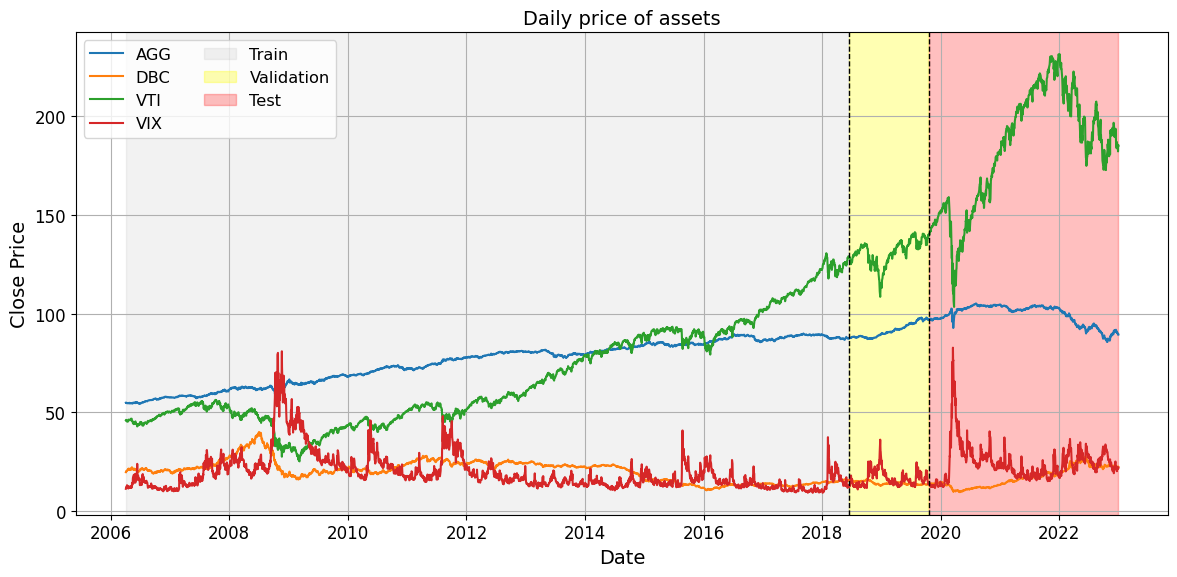

In [483]:
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# ASSUMPTIONS:
#  - `close_df` is a pandas.DataFrame with a datetime-like index,
#    and columns corresponding to each ticker/asset.
#  - `train_indices`, `val_indices`, `test_indices` are each lists/arrays of
#    index labels (e.g. dates) in `close_df.index` that define the three splits.
#  - `colors` is a colormap or function such that `colors(i)` returns a distinct color for asset i.
# -----------------------------------------------------------------------------


plt.figure(figsize=(12, 6))
plt.rcParams.update({
    "font.size": 14,            # base font size for labels, ticks, legend text
    "axes.titlesize": 14,       # title font size
    "axes.labelsize": 14,       # x/y axis label font size
    "xtick.labelsize": 12,      # x-axis tick label font size
    "ytick.labelsize": 12,      # y-axis tick label font size
    "legend.fontsize": 12,      # legend text font size
})

for i, ticker in enumerate(close_df.columns):
    asset_color = colors(i)  # same color for train/val/test segments of this ticker
    
    # Plot the three segments. Only label on the "Train" segment; suppress legend for Val/Test.
    for idx, label in zip(
        [train_indices, val_indices, test_indices],
        ["Train", "Val", "Test"]
    ):
        if label == "Train":
            plot_label = ticker
        else:
            plot_label = "_nolegend_"
        
        plt.plot(
            close_df.loc[idx, ticker],
            color=asset_color,
            label=plot_label
        )

# Compute start/end dates for shading
val_start   = min(val_indices)
val_end     = max(val_indices)
test_start  = min(test_indices)
test_end    = max(test_indices)

# Shade validation and test regions with more vibrant colors:
plt.axvspan(trainval_start, val_start, color="grey",   alpha=0.1, label="Train")
plt.axvspan(val_start, val_end,   color="yellow", alpha=0.3, label="Validation")
plt.axvspan(test_start, test_end, color="red",   alpha=0.25, label="Test")


# Add dashed vertical lines at split points
plt.axvline(val_start,  color="black", linestyle="--", linewidth=1)
plt.axvline(test_start, color="black", linestyle="--", linewidth=1)

# Labels, legend, grid, etc.
plt.title("Daily price of assets")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc="upper left", fontsize="small", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


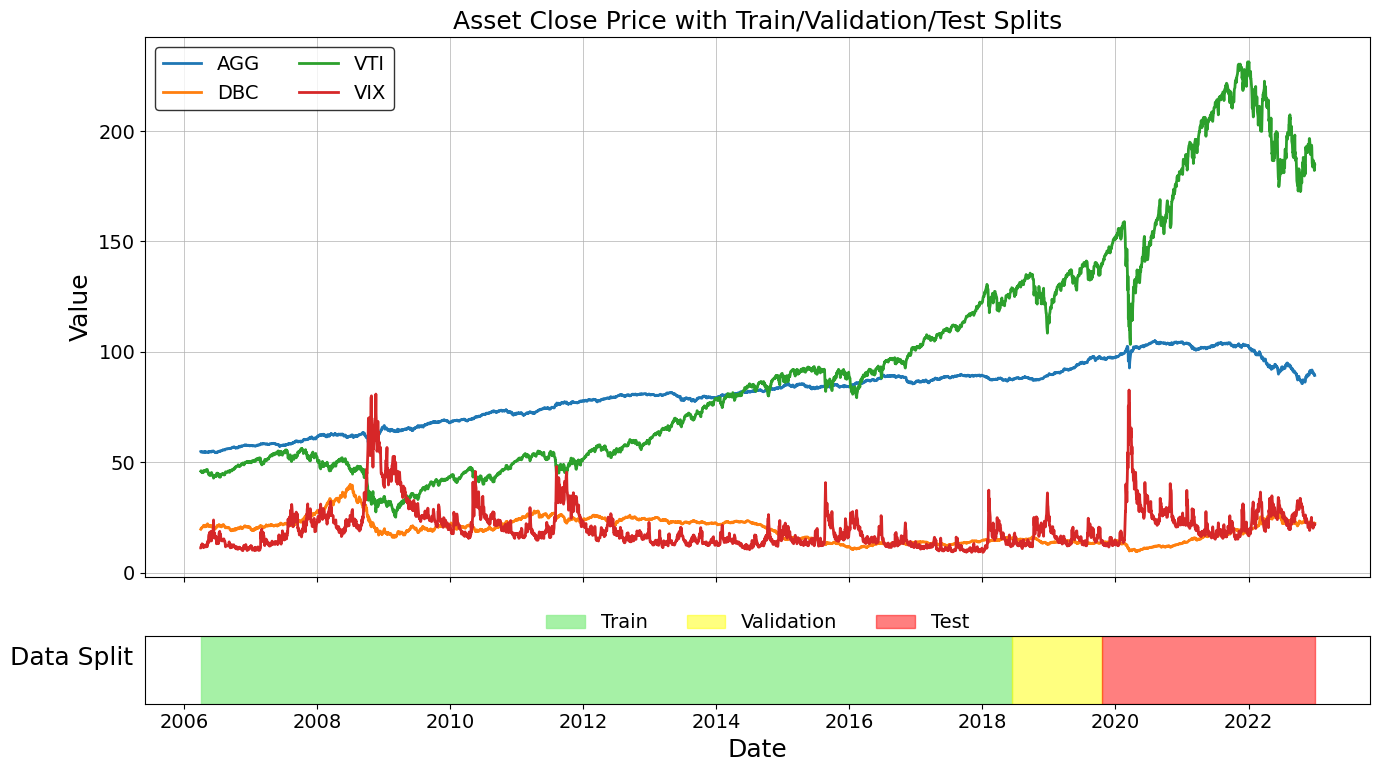

In [489]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# -----------------------------------------------------------------------------
# ASSUMPTIONS:
#  - `close_df` is a pandas.DataFrame with a datetime-like index,
#    and columns corresponding to each ticker/asset.
#  - `train_indices`, `val_indices`, `test_indices` are each lists/arrays of
#    datetime-like index labels (e.g. pandas Timestamp) in `close_df.index` that define the three splits.
#  - `colors` is a colormap or function such that `colors(i)` returns a distinct color for asset i.
# -----------------------------------------------------------------------------

# Increase default font sizes for PDF readability
plt.rcParams.update({
    "font.size": 16,            # base font size for labels, ticks, legend text
    "axes.titlesize": 18,       # title font size
    "axes.labelsize": 18,       # x/y axis label font size
    "xtick.labelsize": 14,      # x-axis tick label font size
    "ytick.labelsize": 14,      # y-axis tick label font size
    "legend.fontsize": 14,      # legend text font size
})

# Compute start and end dates for each split
train_start = min(train_indices)
train_end = max(train_indices)
val_start = min(val_indices)
val_end = max(val_indices)
test_start = min(test_indices)
test_end = max(test_indices)

# Create subplots: main plot on top, timeline on bottom
fig, (ax_main, ax_timeline) = plt.subplots(
    2, 1, sharex=True,
    gridspec_kw={'height_ratios': [8, 1]},
    figsize=(14, 8)
)

# 1) Plot each asset on the main axes
for i, ticker in enumerate(close_df.columns):
    asset_color = colors(i)
    # Plot Train, Validation, Test segments: only label Train for legend
    for idx, label in zip([train_indices, val_indices, test_indices], ["Train", "Val", "Test"]):
        plot_label = ticker if label == "Train" else "_nolegend_"
        ax_main.plot(
            close_df.loc[idx, ticker],
            color=asset_color,
            linewidth=2,
            label=plot_label
        )

ax_main.set_title("Asset Close Price with Train/Validation/Test Splits")
ax_main.set_ylabel("Value")
ax_main.grid(True, linewidth=0.5)
ax_main.legend(loc="upper left", fontsize="14", ncol=2, frameon=True, edgecolor="black")

# 2) Create the timeline: colored boxes for each split
#    We'll use ax_timeline.axvspan to draw colored regions at y=[0, 1] for each split.
ax_timeline.axvspan(train_start, train_end, color="lightgreen", alpha=0.8, label="Train")
ax_timeline.axvspan(val_start, val_end, color="yellow", alpha=0.5, label="Validation")
ax_timeline.axvspan(test_start, test_end, color="red", alpha=0.5, label="Test")

# Remove y-axis details for timeline
ax_timeline.set_yticks([])
ax_timeline.set_ylabel("Data Split", rotation=0, labelpad=40)
ax_timeline.yaxis.set_label_coords(-0.06, 0.5)
ax_timeline.grid(False)

# Format x-axis as dates
ax_timeline.xaxis.set_major_locator(mdates.AutoDateLocator())
ax_timeline.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

# Add legend for the timeline in the timeline subplot
ax_timeline.legend(loc="center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.2))

plt.xlabel("Date")
plt.tight_layout(h_pad=1.0)
plt.show()


In [340]:
def create_windows(data, indices, lookback, horizon):
    X, y = [], []
    index_list = []

    for i in range(len(indices) - lookback - horizon):
        # print(i)
        window_start = indices[i]
        input_end = indices[i + lookback]
        output_end = indices[i + lookback + horizon]

        x_window = data.loc[window_start:input_end].iloc[:-1].values  # shape: (lookback, features)
        y_window = data.loc[input_end:output_end].iloc[:horizon].values  # shape: (horizon, features)
        
        X.append(x_window)
        y.append(y_window)
        index_list.append(input_end)  # center timestamp for reference

    return np.array(X), np.array(y), index_list


lookback = 50   # e.g., past 20 time steps
horizon = 5     # predict next 5 steps
allocation_step = 5

X_train, y_train, train_idx = create_windows(returns_df, train_indices, lookback, horizon)
X_val, y_val, val_idx = create_windows(returns_df, val_indices, lookback, horizon)
X_test, y_test, test_idx = create_windows(returns_df, test_indices, lookback, horizon)

batch_size = 28

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


num_samples, seq_len, num_assets = X_train_tensor.shape
flattened = X_train_tensor.reshape(-1, num_assets)

mean = flattened.mean(dim=0)  # shape (num_assets,)
std = flattened.std(dim=0)    # shape (num_assets,)

# Avoid division by zero
std[std == 0] = 1.0

# Standardize each dataset with training mean and std
def standardize(x, mean, std):
    return (x - mean.view(1, 1, -1)) / std.view(1, 1, -1)

X_train_tensor = standardize(X_train_tensor, mean, std)
X_val_tensor = standardize(X_val_tensor, mean, std)
X_test_tensor = standardize(X_test_tensor, mean, std)

# Save mean and std for later use
saved_mean = mean
saved_std = std

/tmp/ipykernel_395219/2135482227.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


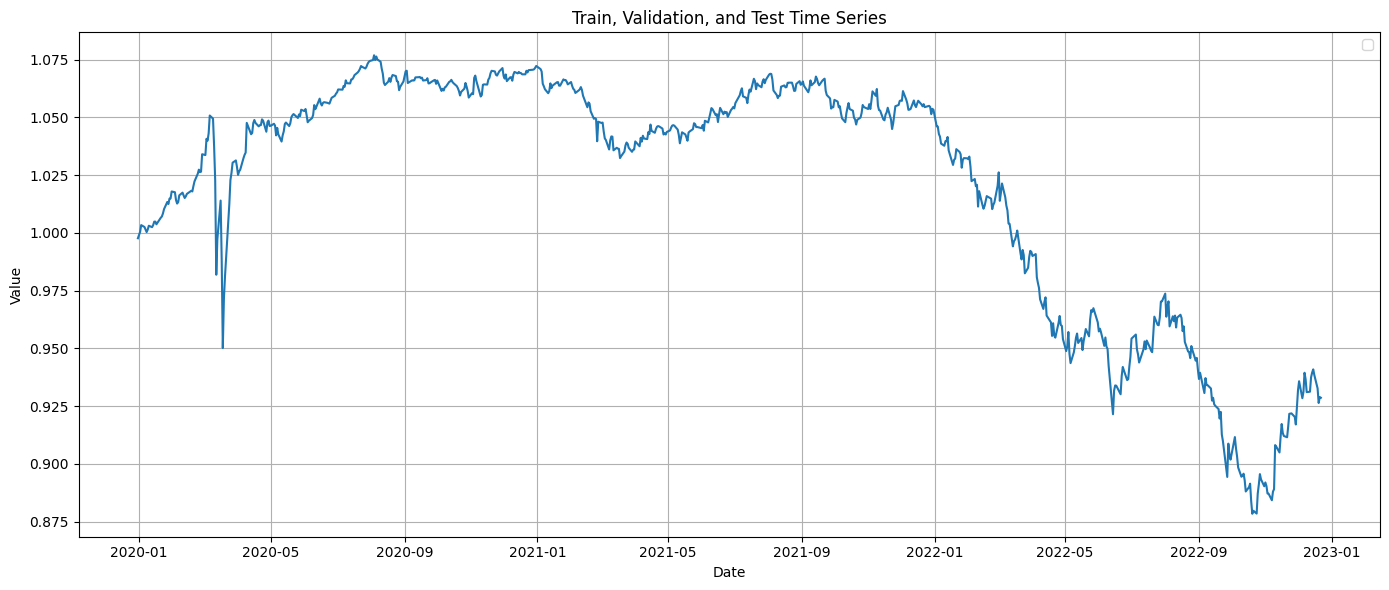

In [341]:
plt.figure(figsize=(14, 6))

# for i, ticker in enumerate(close_df.columns):
#     for idx, label, line in zip([train_indices, val_indices, test_indices], ["Train", "Val", "Test"], [1,2,3]):
plt.plot(test_idx, (y_test[:, :1, :].squeeze(1) + 1).cumprod(0)[:,0])

# plt.plot(close_df.loc[test_indices]["AGG"] - 97)



plt.title('Train, Validation, and Test Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [342]:
from torch.utils.data import Dataset


class Jitter:
    def __init__(self, sigma):
        self.sigma = sigma.view(1, -1)  # shape (1, num_assets), for broadcasting

    def __call__(self, x):
        noise = torch.randn_like(x) * self.sigma  # apply per-asset noise
        return x + noise
    
class AugmentedTimeSeriesDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transform:
            x = self.transform(x)
        return x, self.y[idx]
    

asset_std = X_train_tensor.reshape(-1, X_train_tensor.shape[-1]).std(dim=0)
sigma = 0.025*asset_std
jitter = Jitter(sigma=sigma)
# train_dataset = AugmentedTimeSeriesDataset(X_train_tensor, y_train_tensor, transform=jitter)


train_dataset = AugmentedTimeSeriesDataset(X_train_tensor, y_train_tensor, transform=jitter)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model Defs

In [343]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomTCN(nn.Module):
    def __init__(self):
        super(CustomTCN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3, padding=2, dilation=2)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 3), padding=(0, 1))
        self.relu2 = nn.ReLU()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 1 * 50, 100)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(100, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.transpose(1, 2)  # (B, 4, 50) for Conv1d
        # x = F.pad(x, (2 * 2, 0))  # Causal padding for dilation=2
        x = self.conv1(x)        # (B, 16, 50)
        # x = x[:, :, -50:]
        x = self.relu1(x)

        x = x.unsqueeze(2)       # (B, 16, 1, 50)
        x = self.conv2(x)        # (B, 32, 1, 50)
        x = self.relu2(x)

        x = self.flatten(x)      # (B, 1600)
        x = self.fc1(x)          # (B, 100)
        x = self.relu3(x)
        x = self.fc2(x)          # (B, 4)
        # x /= 5
        x = self.softmax(x)
        return x
    

# model = CustomTCN()
# print(sum(p.numel() for p in model.parameters() if p.requires_grad))

In [344]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.pad = kernel_size - 1
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size)

    def forward(self, x):
        # Left-pad to preserve causality
        x = F.pad(x, (self.pad, 0))  # (left, right)
        return self.conv(x)

# class CNNAllocatorCausal(nn.Module):
#     def __init__(self, input_channels=4, time_steps=50, hidden_size=100, temperature=1.0, dropout_rate=0.3):
#         super().__init__()
#         self.temperature = temperature

#         self.conv1 = CausalConv1d(in_channels=input_channels, out_channels=32, kernel_size=3)
        
#         self.conv2 = CausalConv1d(in_channels=32, out_channels=64, kernel_size=3)
#         self.relu = nn.ReLU()

#         self.dropout = nn.Dropout(dropout_rate)

#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(64 * time_steps, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, input_channels)

#     def forward(self, x):
#         # x: (B, T, N) → (B, N, T)
#         x = x.transpose(1, 2)

#         x = self.relu(self.conv1(x))
#         x = self.dropout(x)

#         x = self.relu(self.conv2(x))
#         x = self.dropout(x)

#         x = self.flatten(x)
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)

#         x = self.fc2(x)
#         return F.softmax(x / self.temperature, dim=1)




In [345]:
def MR_Loss(weights, y):
    weights = weights.unsqueeze(1)
    return (-weights * y).mean()

def enhanced_loss(weights, y, lambda_risk=1.0, lambda_entropy=0.01):
    # print(weights.shape, y.shape)

    portfolio_returns = (weights * y.sum(dim=1)).sum(dim=1)
    # total_return = torch.einsum("bi,bij->b", weights, y.sum(dim=1)) 


    loss = -portfolio_returns.mean()
    loss += lambda_risk * portfolio_returns.var()
    loss -= lambda_entropy * (-(weights * torch.log(weights + 1e-8)).sum(dim=1).mean())

    return loss

In [346]:
def sharpe_ratio(returns):
    mean_return = np.mean(returns)
    volatility = np.std(returns)
    return mean_return / volatility

def max_drawdown(cum_returns):
    peak = np.maximum.accumulate(cum_returns)
    drawdowns = (cum_returns - peak) / (peak + 1e-8)
    return -drawdowns.min()

def entropy(weights):
    entropy = -torch.sum(weights * torch.log(weights + 1e-8), dim=1)  # (T,)
    return entropy

def mean_entropy(weights):
    entropy = -torch.sum(weights * torch.log(weights + 1e-8), dim=1)  # (T,)
    return entropy.mean().item()

In [347]:
def reallocte_weights(weights, step):
    n = weights.shape[0]
    weights = weights[::step]
    weights = weights.unsqueeze(1).repeat(1, step, 1).view(-1, 4)[:n]
    return weights


In [348]:
class CustomSoftmax(nn.Module):
    def __init__(self, dim: int = -1):
        super(CustomSoftmax, self).__init__()
        self.dim = dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_exp = torch.exp(x)
        return  x_exp * (1 / x_exp.sum(dim=self.dim).unsqueeze(self.dim))

class SimpleAssetAllocationModel(nn.Module):
    def __init__(self, input_channels=4, output_channels=4):
        super(SimpleAssetAllocationModel, self).__init__()
        
        input_size = input_channels
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_channels)
        self.softmax = CustomSoftmax(dim=-1)

        # self.fc4 = nn.Linear(4*50, 4)

    def forward(self, x):

        x = torch.flatten(x, start_dim=-2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)    
    
class CNNAllocatorCausal(nn.Module):
    def __init__(self, input_channels=4, time_steps=50, hidden_size=100, dropout_rate=0.1):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * time_steps, hidden_size)
        self.fc2 = nn.Linear(hidden_size, input_channels)
        self.softmax = CustomSoftmax(dim=-1)

    def forward(self, x):
        # x: (B, T, N) → (B, N, T)
        x = x.transpose(1, 2)

        x = self.relu(self.conv1(x))
        # x = self.dropout(x)

        x = self.relu(self.conv2(x))
        # x = self.dropout(x)

        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        # x = self.dropout(x)

        x = self.fc2(x)
        
        return self.softmax(x)

class UniformModel(nn.Module):
    def __init__(self):
        super(UniformModel, self).__init__()

    def forward(self, x):
        b = x.shape[0]
        return torch.full((b, n_assets), 1/n_assets, device=x.device, dtype=x.dtype)
    
class FixedWeightModel(nn.Module):
    def __init__(self, default_weights):
        super(FixedWeightModel, self).__init__()
        self.weights = default_weights
    def forward(self, x):
        b = x.shape[0]
        return self.weights.to(x.device, dtype=x.dtype).expand(b, -1)

## Experiments

In [349]:
import itertools, json, time

def grid_to_sets(grids):
    if not isinstance(grids, list):
        grids = [grids]  # Wrap single grid in a list

    all_combinations = []
    for grid in grids:
        keys = grid.keys()
        combinations = [dict(zip(keys, values)) for values in itertools.product(*grid.values())]
        all_combinations.extend(combinations)

    return all_combinations

def model_file_name(params):
    model_name = ",".join(
            f"{key}={val}" for key, val in params.items() if val is not None
        ) + ".pth"
    return model_name

In [350]:
def get_portfiolio_value(model, data, rebalance_freq):
    portfolio_values = []
    x, y = data[0], data[1].numpy()

    model.eval()
    n = y.shape[0]
    total_value = 1

    weights = []

    for t in range(0, n, rebalance_freq):
        x = x.to(device)
        current_weights = model(x[t:t+1]).detach().cpu().numpy()
        asset_values = total_value * current_weights
        weights.extend([current_weights] * rebalance_freq)
        portfolio_values.extend((1 + y[t:t+rebalance_freq]).cumprod(0) * asset_values)
        asset_values *= (1 + y[t:t+rebalance_freq]).prod(0)
        total_value = asset_values.sum()

    portfolio_values = np.array(portfolio_values)
    weights = np.array(weights)

    return portfolio_values.sum(1), weights[:n], portfolio_values

In [351]:
def run_experiment(model, data, experiment={}):

    # print(experiment)
    params = experiment.get("params", {})
    # print(params)
    rebalance_freq = params.get("rebalance_freq", 252)
    # print(rebalance_freq)
    x, y = data
    # y = y.to(device)
    model.eval()
    n = y.shape[0]

    # weights = model(x)
    # weights = reallocte_weights(weights, rebalance_freq)

    # print(weights.shape)



    # portfolio_values, weights, holdings = get_portfiolio_value(model, data, rebalance_freq)

    portfolio_values,weights,holdings = get_portfiolio_value(model, data, rebalance_freq)

    # weights = []
    # holdings = []
    

    weights = torch.tensor(weights).squeeze(1)
    holdings = torch.tensor(holdings).squeeze(1)


    # returns = portfolio_values.
    cum_returns = portfolio_values - 1

    returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]

    # Daily metrics
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    sharpe = sharpe_ratio(returns)

    # # Annualized versions
    # annual_return = mean_return * trading_days
    # annual_volatility = std_return * np.sqrt(trading_days)
    # annual_sharpe = annual_return / annual_volatility if annual_volatility > 0 else 0.0

    metrics = {
        "expected_return": cum_returns[-1].item(),
        "sharpe_ratio": sharpe,
        # "annual_return": annual_return,
        # "annual_volatility": annual_volatility,
        # "annual_sharpe_ratio": annual_sharpe,
        "max_drawdown": max_drawdown(portfolio_values),
        "mean_entropy": mean_entropy(weights),
        "mean_return": mean_return,
        "std_return": std_return,
    }

    raw = {
        "weights": weights,
        "returns": returns,
        "cum_returns": cum_returns,
        "holdings": holdings,
    }

    return {"metrics": metrics, "raw": raw}




In [352]:
def label_from_params2(params, all_params):
    nested = all_params

    ps = {}
    for k,v in [item for sublist in nested for item in sublist]:
        if k in ps:
            ps[k].add(v)
        else:
            ps[k] = {v}

    params_to_use = []

    for k,v in ps.items():
        if len(v) > 1:
            params_to_use.append(k)

    if "label" in params:
        label = params["label"] + " "
    else:
        label = ""

    return label + " ".join(
                f"{key}={val}" for key, val in params.items() if key in params_to_use and key != "label"
            )

In [353]:
def label_from_params(params, experiments):
    nested = [list(v["params"].items()) for k, v in experiments.items()]

    ps = {}
    for k,v in [item for sublist in nested for item in sublist]:
        if k in ps:
            ps[k].add(v)
        else:
            ps[k] = {v}

    params_to_use = []

    for k,v in ps.items():
        if len(v) > 1:
            params_to_use.append(k)

    if "label" in params:
        label = params["label"] + " "
    else:
        label = ""

    return label + " ".join(
                f"{key}={val}" for key, val in params.items() if key in params_to_use and key != "label"
            )

In [354]:
def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [355]:
from tqdm import tqdm 

In [395]:
def train_step(model, device, loader, optimizer, loss_fn, params={}, mode="train"):
    model.train()
    gradient_clipping = params.get("gradient_clipping", None)

    is_train = mode == "train"
    if is_train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    num_batches = 0

    context = torch.enable_grad() if is_train else torch.no_grad()

    with context:

        for x, y in loader:
            x, y = x.to(device), y.to(device)

            if is_train:
                optimizer.zero_grad()    

            loss = loss_fn(x, y, model)      
            
            if is_train:
                loss.backward()

                if gradient_clipping:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clipping)

                
                optimizer.step()
            total_loss += loss.item()
            num_batches += 1

    return total_loss / max(1, num_batches)


# 

def get_experiment_model(model_fn, experiment_path, params_grid, loss_fn_fn):
    experiments = {}

    train_result_path = os.path.join(experiment_path, "train_results.csv")
    os.makedirs(os.path.dirname(train_result_path), exist_ok=True)
    if os.path.exists(train_result_path):
        with open(train_result_path, 'r') as file:
            train_results = json.load(file)
    else:
        train_results = {}

    param_sets = grid_to_sets(params_grid)

    for params in param_sets:
        # name = f"{}"
        epochs = params.get("epochs", 10)
        checkpoint_freq = params.get("checkpoint_freq", epochs)
        
        paths = {}
        for epoch in range(1, epochs + 1):
            if epoch % checkpoint_freq == 0 or epochs==epoch: 
                name = model_file_name(params | {"checkpoint": epoch})
                model_path = os.path.join(experiment_path, name)
                paths[epoch] = model_path

        load_checkpoint = params.get("checkpoint", None)
        if load_checkpoint is not None:
            paths = {load_checkpoint: paths[load_checkpoint]}
            del params["checkpoint"]
            print(params)
      
       
        if all([os.path.exists(p) for p in paths.values()]):
            for checkpoint, path in paths.items():
                print("Loading", path)
                checkpoint_params = params | {"checkpoint": checkpoint}
                name = model_file_name(checkpoint_params)
                model_path = os.path.join(experiment_path, name)
                model = model_fn(params)
                model.load_state_dict(torch.load(model_path, map_location=device))
                experiments[name] = {"model": model, "params": checkpoint_params, "results": {}, "train_results": train_results[model_path]}
        else:
            print("Training", label_from_params(params, experiments))
            if "seed" in params:
                set_seed(params["seed"])
            model = model_fn(params)
            loss_fn = loss_fn_fn(params)
            train_losses = []
            val_losses = []
            lr = params.get("learning_rate", 0.001)
            weight_decay = params.get("weight_decay", 1e-5)
            
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            train_time = 0
            pbar = tqdm(range(1, epochs + 1), desc="Epochs", unit="ep")
            for epoch in pbar:
                start_time = time.time()
                train_loss  = train_step(model, device, train_loader, optimizer, loss_fn, params, "train")
                train_time += time.time() - start_time

                val_loss = train_step(model, device, test_loader, optimizer, loss_fn, params, "eval")
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                pbar.set_postfix(train_loss=f"{train_loss:.5f}",val_loss=f"{val_loss:.5f}")

                if epoch % checkpoint_freq == 0 or epoch == epochs:
                    checkpoint_params = params | {"checkpoint": epoch}
                    name = model_file_name(checkpoint_params)
                   
                    model_path = os.path.join(experiment_path, name)
                    print("Saving", name)
                    train_results[model_path] = {"train_time": train_time, "train_losses": train_losses.copy(), "val_losses": val_losses.copy()}
                    torch.save(model.state_dict(), model_path)

                    checkpoint_model = model_fn(params)
                    checkpoint_model.load_state_dict(torch.load(model_path, map_location=device))
                    experiments[name] = {"model": checkpoint_model, "params": checkpoint_params, "results": {}, "train_results": train_results[model_path]}
                    with open(train_result_path, 'w') as file: 
                        json.dump(train_results, file, indent=4)
                
    return experiments

In [357]:
import random

In [358]:
# def get_experiment_model(model_fn, experiment_path, params_grid, loss_fn_fn):
#     experiments = {}

#     train_result_path = os.path.join(experiment_path, "train_results.csv")
#     os.makedirs(os.path.dirname(train_result_path), exist_ok=True)
#     if os.path.exists(train_result_path):
#         with open(train_result_path, 'r') as file:
#             train_results = json.load(file)
#     else:
#         train_results = {}

#     for params in grid_to_sets(params_grid):
#         name = f"{model_file_name(params)}"
#         model_path = os.path.join(experiment_path, name)

#         if "seed" in params:
#             set_seed(params["seed"])

#         model = model_fn(params)
#         loss_fn = loss_fn_fn(params)

#         if os.path.exists(model_path):
#             print("Loading", label_from_params(params, experiments))
#             model.load_state_dict(torch.load(model_path, map_location=device))
#         else:
#             print("Training", label_from_params(params, experiments))
#             start_time = time.time()
#             train_losses, val_losses = train_model_final(model, device, train_loader, val_loader, loss_fn, params)
#             train_time = time.time() - start_time
#             torch.save(model.state_dict(), model_path)
#             train_results[model_path] = {"train_time": train_time, "train_losses": train_losses, "val_losses": val_losses}
#             with open(train_result_path, 'w') as file: 
#                 json.dump(train_results, file, indent=4)
            
#         experiments[name] = {"model": model, "params": params, "results": {}, "train_results": train_results[model_path] }
#     return experiments



In [413]:
def default_linestyle_map(params):
    return "-"

def display_train_results(experiments):
    plt.figure(figsize=(10, 6))
    colors = cm.get_cmap('tab10')

    for idx, (_, experiment) in enumerate(experiments.items()):
        if "train_results" not in experiment:
            continue
        label = label_from_params(experiment["params"], experiments)
        
        data = experiment["train_results"]
        epochs = list(range(1, len(data["train_losses"]) + 1))
        color = colors(idx % 10) 

        plt.plot(epochs, data["train_losses"], label=f"{label} - Train", linestyle='-', color=color)
        plt.plot(epochs, data["val_losses"], label=f"{label} - Val", linestyle='--', color=color)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def display_experiment_results(experiments, dataset_key, dataset_idx, linestyle_map=default_linestyle_map, label_from_params=label_from_params, additional_detail=False):
    metrics_df  = pd.DataFrame({label_from_params(v["params"], experiments): v['results'][dataset_key]["metrics"] for k, v in experiments.items()}).T
    metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)
    display(metrics_df)

    plt.figure(figsize=(10, 6))
    for params, cr in [(v["params"], v['results'][dataset_key]["raw"]["cum_returns"]) for k, v in experiments.items()]:

        print(cr.shape)
        plt.plot(dataset_idx, cr, label=label_from_params(params, experiments), linestyle=linestyle_map(params))

    plt.title(f"Cumulative Returns of Different Models ({dataset_key.title()})")
    plt.xlabel("Time Step")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    ncols = 2
    nrows = math.ceil(len(experiments.items()) / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 5 * nrows))
    axes = axes.flatten()

    # Loop through and plot
    for i, (params, weights) in enumerate([(v["params"], v['results'][dataset_key]["raw"]["weights"]) for k, v in experiments.items()]):
        ax = axes[i]
        ax.stackplot(dataset_idx, weights.T.detach().numpy(), labels=asset_names)
        ax.set_title(f'Stacked Area Plot of Asset Allocations ({label_from_params(params, experiments)})')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Proportion')
        ax.legend(loc='upper left')
        ax.grid(True)

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    if additional_detail:

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 5 * nrows))
        axes = axes.flatten()

        # Loop through and plot
        for i, (params, holding) in enumerate([(v["params"], v['results'][dataset_key]["raw"]["holdings"]) for k, v in experiments.items()]):
            ax = axes[i]
            ax.plot(dataset_idx, holding.detach().numpy(), label=asset_names)
            ax.set_title(f'Stacked Area Plot of Asset Allocations ({label_from_params(params, experiments)})')
            ax.set_xlabel('Time Step')
            ax.set_ylabel('Proportion')
            ax.legend(loc='upper left')
            ax.grid(True)

        # Hide any unused axes
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 6))

        for params, weights in [(v["params"], v['results'][dataset_key]["raw"]["weights"]) for k, v in experiments.items()]:
            if "epochs" not in params:
                continue
            plt.plot(dataset_idx, entropy(weights).detach().numpy(), label=label_from_params(params, experiments))

        plt.axhline(np.log(n_assets), color='gray', linestyle='--', label='Max Entropy (Uniform)')
        plt.title(f'Allocation Entropy Over Time ({dataset_key.title()})')
        plt.xlabel('Date')
        plt.ylabel('Entropy')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return metrics_df    

# Standard Training

## Param tuning entropy

In [360]:
import random as random
import time as time

In [361]:
import torch.nn as nn
import torch
from torch.nn import functional as F


class MLP(nn.Module):
    def __init__(self, input_size, output_size=1):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        x = self.model(x)
        return x 

class CNN(nn.Module):
    def __init__(self, input_size, output_size=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear((input_size - 2) * 64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        x = x.unsqueeze(1) 
        x = self.conv(x)
        x = self.fc(x)
        return x

    
# Custom Multihead Attention (No Dropout)
class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=16):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_k = nn.Linear(dim, inner_dim, bias=False)
        self.to_v = nn.Linear(dim, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _ = x.shape  # batch_size, seq_length, num_features
        q = self.to_q(x)
        k = self.to_k(x)
        v = self.to_v(x)
        
        # Perform attention
        q, k, v = [t.reshape(b, n, self.heads, -1).transpose(1, 2) for t in (q, k, v)]

        # dots = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        # attn = torch.sigmoid(dots) #dots.softmax(dim=-1)

        dots = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        dots = torch.clamp(dots, min=1e-6, max=1.0)  # Ensure no negative or zero values
       

        #Check that this actually does work
        # attn = dots.softmax(dim=-1)
        dots_exp = torch.exp(dots)
        attn = dots_exp / dots_exp.sum(dim=-1, keepdim=True)
        # attn = dots.softmax(dim=-1).clamp(min=1e-6, max=1.0)


        out = torch.matmul(attn, v)
        # out = out.transpose(1, 2).reshape(b, n, -1)
        out = out.transpose(1, 2).contiguous()
        out = out.view(out.size(0), out.size(1), -1)
        out = self.to_out(out)
        return out

# Custom Transformer Encoder Layer (No Dropout)
class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_head=16):
        super(CustomTransformerEncoderLayer, self).__init__()
        self.self_attn = Attention(d_model, heads=nhead, dim_head=dim_head)
        self.linear1 = nn.Linear(d_model, d_model * 4)
        self.linear2 = nn.Linear(d_model * 4, d_model)
        ##This seems to mess up the bounds??
        # self.norm1 = nn.LayerNorm(d_model)
        # self.norm2 = nn.LayerNorm(d_model)
        self.norm1 = nn.Identity()
        self.norm2 = nn.Identity()

    def forward(self, src):
        # Multi-head self attention
        attn_output = self.self_attn(src)
        src = self.norm1(src + attn_output)
        
        # Feedforward network
        ff_output = self.linear2(F.relu(self.linear1(src)))
        src = self.norm2(src + ff_output)
        
        return src

# Custom Transformer Encoder (No Dropout)
class CustomTransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super(CustomTransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])
        self.num_layers = num_layers

    def forward(self, src):
        for layer in self.layers:
            src = layer(src)
        return src

# Transformer2 Model (No Dropout)
class Transformer(nn.Module):
    def __init__(self, input_size, output_size, d_model=4, nhead=2, num_layers=2, dim_head=16):
        super(Transformer, self).__init__()
        self.input_proj = nn.Linear(1, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(input_size, d_model))
        
        # Define the custom transformer encoder
        encoder_layer = CustomTransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_head=dim_head)
        self.transformer = CustomTransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(d_model * input_size, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        # x = x.unsqueeze(-1)  # (B, T, 1)

        x = self.input_proj(x) + self.pos_embedding  # (B, T, d_model)
        
        # Pass through custom transformer encoder
        x = self.transformer(x)
        
        # Flatten the output for fully connected layers
        x = x.flatten(start_dim=1)  # (B, T * d_model)
        return self.fc(x)
    

import torch
import torch.nn as nn

class Transformer(nn.Module):
    def __init__(self, input_size, output_size, d_model=4, nhead=2, num_layers=2, dim_head=16):
        super(Transformer, self).__init__()
        # input_proj now takes 4 input features per time step
        self.input_proj = nn.Linear(4, d_model)
        
        # Positional embeddings: (1, input_size, d_model)
        # Broadcasted to each batch
        self.pos_embedding = nn.Parameter(torch.randn(1, input_size, d_model))
        
        # Custom transformer encoder (you probably have these defined elsewhere)
        encoder_layer = CustomTransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_head=dim_head)
        self.transformer = CustomTransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(d_model * input_size, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        """
        x: (batch_size, seq_len, 4)  # 4 input features (assets)
        """
        # Project 4 input features to d_model
        x = self.input_proj(x)  # (B, T, d_model)
        
        # Add positional encoding (broadcasted across batch dimension)
        x = x + self.pos_embedding  # (B, T, d_model)
        
        # Pass through transformer
        x = self.transformer(x)  # (B, T, d_model)
        
        # Flatten time and d_model dimensions
        x = x.flatten(start_dim=1)  # (B, T * d_model)

        x = self.fc(x)

        x = torch.softmax(x, dim=1)
        
        return x


    
transformer = Transformer(input_size=50,  output_size=4, d_model=2, nhead=2, num_layers=2, dim_head=4)

In [362]:
    
# class LSTM(nn.Module):
#     def __init__(self, input_size=4, hidden_size=64, num_layers=4, num_classes=4):
#         super(LSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers

#         self.lstm_cells = nn.ModuleList([
#             nn.LSTMCell(input_size if i == 0 else hidden_size, hidden_size)
#             for i in range(num_layers)
#         ])
        
#         self.fc = nn.Linear(hidden_size, num_classes)

        
class LSTM_Unrolled(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=4, num_classes=4):
        super(LSTM_Unrolled, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm_cells = nn.ModuleList([
            nn.LSTMCell(input_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = CustomSoftmax(dim=-1)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        h = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]

        for t in range(seq_len):
            input_t = x[:, t, :]
            for i, cell in enumerate(self.lstm_cells):
                h[i], c[i] = cell(input_t, (h[i], c[i]))
                input_t = h[i]

        out = self.fc(h[-1])

        return self.softmax(out)

class LSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=4, num_classes=4):
        super().__init__()
        # self.temperature = temperature

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            )

        self.fc = nn.Linear(50 * hidden_size, num_classes)

    def forward(self, x):
        # LSTM expects (B, 50, 4)
        out, _ = self.lstm(x)   # (B, 50, hidden_size)
        # print(out.shape)
        # out = out[:, -1, :]     # last timestep
        out = out.reshape(out.size(0), -1)
        # print(out.shape)
        out = self.fc(out)      # project to (B, 4)
        return torch.softmax(out, dim=1)

In [363]:
LSTM()

LSTM(
  (lstm): LSTM(4, 64, num_layers=4, batch_first=True)
  (fc): Linear(in_features=3200, out_features=4, bias=True)
)

## CNN

In [364]:
model = LSTM(input_size=4, hidden_size=64, num_layers=4, num_classes=4)
# model = CNNAllocatorCausal(4, lookback).to(device)
# Count total parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 130564


In [378]:
def loss_fn_fn(params):
    lambda_entropy = params["lambda_entropy"]
    def loss_fn(x, y, model):
        weights = model(x)

        asset_returns = ((1 + y).prod(1)-1)
        portfolio_returns = (asset_returns*weights).sum(1)
        natural_loss = -portfolio_returns.mean() 
        clamped_weights = weights.clamp(min=1e-8)
        entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())
        return natural_loss -  entropy_loss
    return loss_fn 
    
def model_fn(params):
    if params["model"] == "CNN":
        return CNNAllocatorCausal(4, lookback).to(device)
    elif params["model"] == "MLP":
        return SimpleAssetAllocationModel(4*lookback).to(device)
    elif params["model"] == "LSTM":
        hidden_size = params["lstm_hidden_layers"]
        num_layers = params["lstm_hidden_layers"]
        return LSTM(n_assets, hidden_size, num_layers, n_assets).to(device)
    elif params["model"] == "LSTM_Unrolled":
        hidden_size = params["lstm_hidden_layers"]
        num_layers = params["lstm_hidden_layers"]
        return LSTM_Unrolled(n_assets, hidden_size, num_layers, n_assets).to(device)
    elif params["model"] == "Transformer":
        return Transformer(input_size=50,  output_size=4, d_model=2, nhead=2, num_layers=2, dim_head=4).to(device)

    raise Exception("Model not found")

    # return model

# params_grids = [{
#     "seed": [3],
#     "epochs": [10],
#     "lambda_entropy": [0.025],
#     "model": ["CNN", "MLP", "Transformer"],
#     # "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "checkpoint_freq": [10]
# },{

params_grids = [{
    "seed": [20],
    "epochs": [100],
    "lambda_entropy": [0.025],
    "model": ["LSTM"],
    "lstm_layers" : [4],
    "lstm_hidden_layers": [2, 1, 3],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "checkpoint_freq": [8]
}
]



# params_grids = [{
#     "seed": [0],
#     "epochs": [10],
#     "lambda_entropy": [0.025],#[0.1e-4, 1e-3, 1e-2, 0.05, 0.1],
#     "model": ["Transformer"],
#     # "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "checkpoint_freq": [10]
# },
# ]

# params_grids = [{
#     "seed": [0],
#     "epochs": [10],
#     "lambda_entropy": [1e-4, 1e-3, 1e-2, 0.05, 0.1],
#     "model": ["MLP"],
#     # "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "checkpoint_freq": [10]
# }]

# params_grids = [{
#     "seed": [2],
#     "epochs": [10],
#     "lambda_entropy": [1e-3],
#     "model": ["Transformer"],
#     # "lstm_layers" : [1],
#     # "lstm_hidden_layers": [32],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "checkpoint_freq": [3]
# }
# ]

# experiment_path = "fyp3/experiments/standard_model/"
# experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)

# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)


# train_df  = pd.DataFrame({label_from_params(v["params"], experiments): v['results']["train"]["metrics"] for k, v in experiments.items()}).T

# val_df  = pd.DataFrame({label_from_params(v["params"], experiments): v['results']["val"]["metrics"] for k, v in experiments.items()}).T
# test_df  = pd.DataFrame({label_from_params(v["params"], experiments): v['results']["test"]["metrics"] for k, v in experiments.items()}).T

# val_df_prefixed = val_df.add_prefix('val_')
# train_df_prefixed = train_df.add_prefix('train_')
# test_df_prefixed = test_df.add_prefix('test_')


# combined_df = pd.DataFrame()
# for df_name in ["train", "val", "test"]:
#     df  = pd.DataFrame({label_from_params(v["params"], experiments): v['results'][df_name]["metrics"] for k, v in experiments.items()}).T
#     df.add_prefix(f'{df_name}_')
#     combined_df = pd.concat([combined_df, df])

# # Combine the two DataFrames on their common index
# combined_df = pd.concat([val_df_prefixed, test_df_prefixed, train_df_prefixed], axis=1)
# combined_df = combined_df.sort_values(by='val_expected_return', ascending=False)
# combined_df[["val_expected_return", "test_expected_return", "train_expected_return"]]

## CNN - Hyperparameter tuning 

In [368]:
# train_df  = pd.DataFrame({label_from_params(v["params"], experiments): v['results']["train"]["metrics"] for k, v in experiments.items()}).T

# val_df  = pd.DataFrame({label_from_params(v["params"], experiments): v['results']["val"]["metrics"] for k, v in experiments.items()}).T
# test_df  = pd.DataFrame({label_from_params(v["params"], experiments): v['results']["test"]["metrics"] for k, v in experiments.items()}).T

# val_df

In [404]:
params_grids = [{
    "seed": [4,5,6],
    "epochs": [30],
    "lambda_entropy": [0.025, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],
    "model": ["CNN"],
    "learning_rate": [1e-3],
    "checkpoint_freq": [10],
    "rebalance_freq": [5]
}
]

experiment_path = "fyp3/experiments/standard_model/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

Loading fyp3/experiments/standard_model/seed=4,epochs=30,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=10.pth
Loading fyp3/experiments/standard_model/seed=4,epochs=30,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=20.pth
Loading fyp3/experiments/standard_model/seed=4,epochs=30,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=30.pth
Loading fyp3/experiments/standard_model/seed=4,epochs=30,lambda_entropy=0.0025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=10.pth
Loading fyp3/experiments/standard_model/seed=4,epochs=30,lambda_entropy=0.0025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=20.pth
Loading fyp3/experiments/standard_model/seed=4,epochs=30,lambda_entropy=0.0025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=30.pth
Training lambda_entropy=0

Epochs:  33%|▎| 10/30 [00:05<00:11,  1.70ep/s, train_loss=-0.07886, val_loss=-0.

Saving seed=5,epochs=30,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=10.pth


Epochs:  67%|▋| 20/30 [00:11<00:06,  1.65ep/s, train_loss=-0.08297, val_loss=-0.

Saving seed=5,epochs=30,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=20.pth


Epochs: 100%|█| 30/30 [00:16<00:00,  1.86ep/s, train_loss=-0.08338, val_loss=-0.


Saving seed=5,epochs=30,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=30.pth
Training seed=5 lambda_entropy=0.0025


Epochs:  33%|▎| 10/30 [00:04<00:10,  1.96ep/s, train_loss=-0.04852, val_loss=-0.

Saving seed=5,epochs=30,lambda_entropy=0.0025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=10.pth


Epochs:  67%|▋| 20/30 [00:09<00:04,  2.21ep/s, train_loss=-0.05928, val_loss=-0.

Saving seed=5,epochs=30,lambda_entropy=0.0025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=20.pth


Epochs: 100%|█| 30/30 [00:13<00:00,  2.16ep/s, train_loss=-0.05872, val_loss=-0.


Saving seed=5,epochs=30,lambda_entropy=0.0025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=30.pth
Training seed=6 lambda_entropy=0.025


Epochs:  33%|▎| 10/30 [00:04<00:10,  1.91ep/s, train_loss=-0.07887, val_loss=-0.

Saving seed=6,epochs=30,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=10.pth


Epochs:  67%|▋| 20/30 [00:09<00:05,  1.82ep/s, train_loss=-0.08334, val_loss=-0.

Saving seed=6,epochs=30,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=20.pth


Epochs: 100%|█| 30/30 [00:14<00:00,  2.08ep/s, train_loss=-0.08405, val_loss=-0.


Saving seed=6,epochs=30,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=30.pth
Training seed=6 lambda_entropy=0.0025


Epochs:  33%|▎| 10/30 [00:04<00:07,  2.73ep/s, train_loss=-0.04563, val_loss=-0.

Saving seed=6,epochs=30,lambda_entropy=0.0025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=10.pth


Epochs:  67%|███▎ | 20/30 [00:09<00:05,  1.79ep/s, train_loss=nan, val_loss=nan]

Saving seed=6,epochs=30,lambda_entropy=0.0025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=20.pth


Epochs: 100%|█████| 30/30 [00:14<00:00,  2.11ep/s, train_loss=nan, val_loss=nan]


Saving seed=6,epochs=30,lambda_entropy=0.0025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=30.pth


In [405]:
combined_df = pd.DataFrame({label_from_params(v["params"], experiments): v['params'] for k, v in experiments.items()}).T
params = list(combined_df.columns)
for df_name in ["val", "test"]:
    df  = pd.DataFrame({label_from_params(v["params"], experiments): v['results'][df_name]["metrics"] for k, v in experiments.items()}).T
    df = df.add_prefix(f'{df_name}_')
    combined_df = pd.concat([combined_df, df], axis=1)

params.remove("seed")
metric = "val_expected_return"
combined_df = combined_df.groupby(params)[metric].mean().reset_index().sort_values(metric, ascending=False).dropna().rename(columns={metric: f"mean_{metric}"})
display(combined_df)
best_params = combined_df[params].iloc[0].to_dict()
print(best_params)
best_CNN_params = best_params

epochs  lambda_entropy model  learning_rate  checkpoint_freq  \
0      30          0.0025   CNN          0.001               10   
1      30          0.0025   CNN          0.001               10   
2      30          0.0025   CNN          0.001               10   
4      30          0.0250   CNN          0.001               10   
5      30          0.0250   CNN          0.001               10   
3      30          0.0250   CNN          0.001               10   

   rebalance_freq  checkpoint  mean_val_expected_return  
0               5          10                  2.567099  
1               5          20                  2.388683  
2               5          30                  1.760573  
4               5          20                  1.418095  
5               5          30                  1.205476  
3               5          10                  1.130917

{'epochs': 30, 'lambda_entropy': 0.0025, 'model': 'CNN', 'learning_rate': 0.001, 'checkpoint_freq': 10, 'rebalance_freq': 5, 'checkpoint': 10}


/tmp/ipykernel_395219/2067568222.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


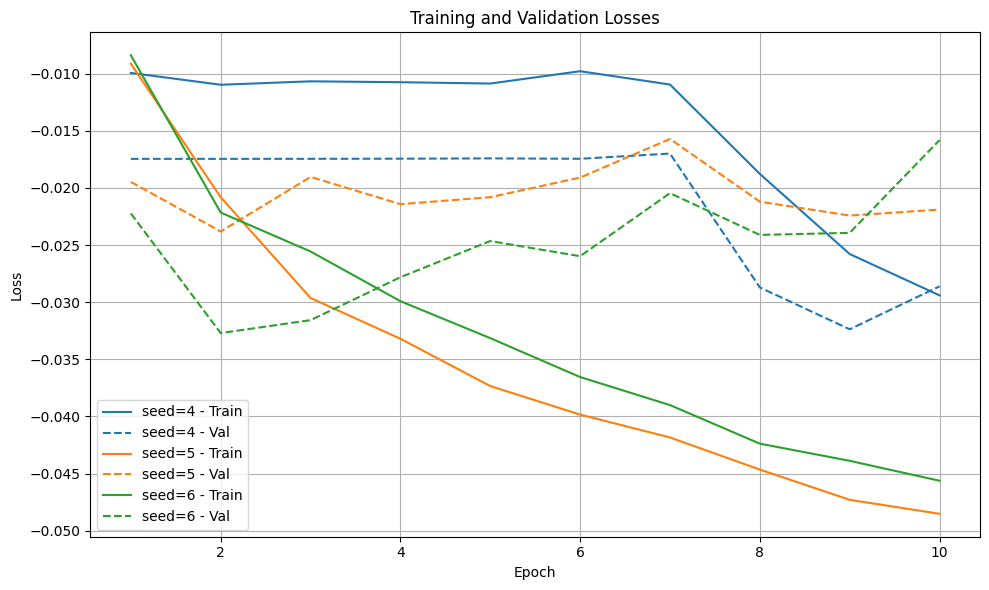

--------------------
Test RESULTS
--------------------


/tmp/ipykernel_395219/2067568222.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


expected_return sharpe_ratio max_drawdown mean_entropy mean_return  \
seed=4              16       0.0961        0.501         0.33     0.00507   
seed=5            12.6        0.084        0.558        0.328     0.00523   
seed=6            7.89       0.0778        0.462        0.287     0.00427   

       std_return  
seed=4     0.0528  
seed=5     0.0623  
seed=6     0.0549

(752,)
(752,)
(752,)


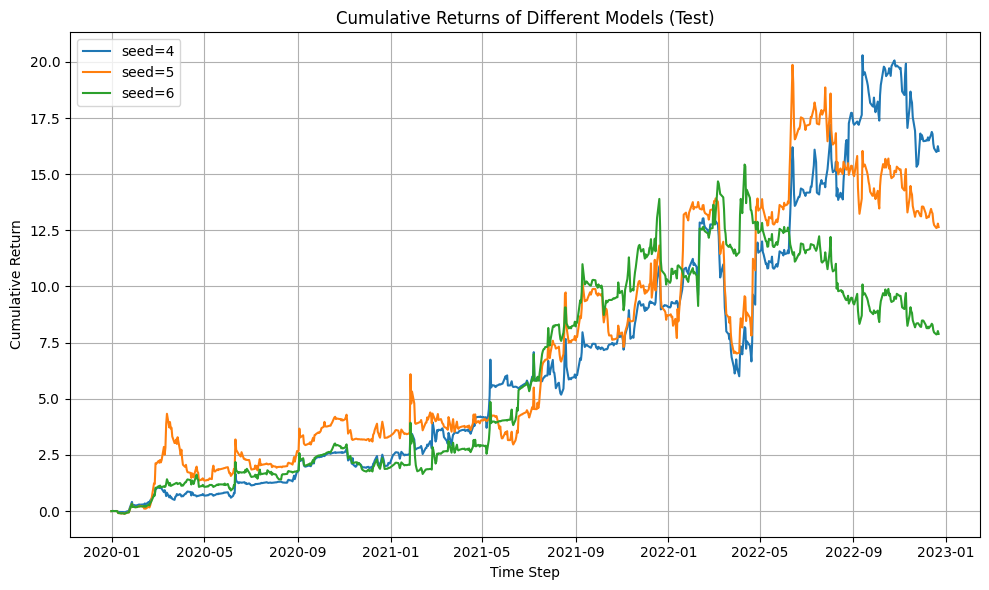

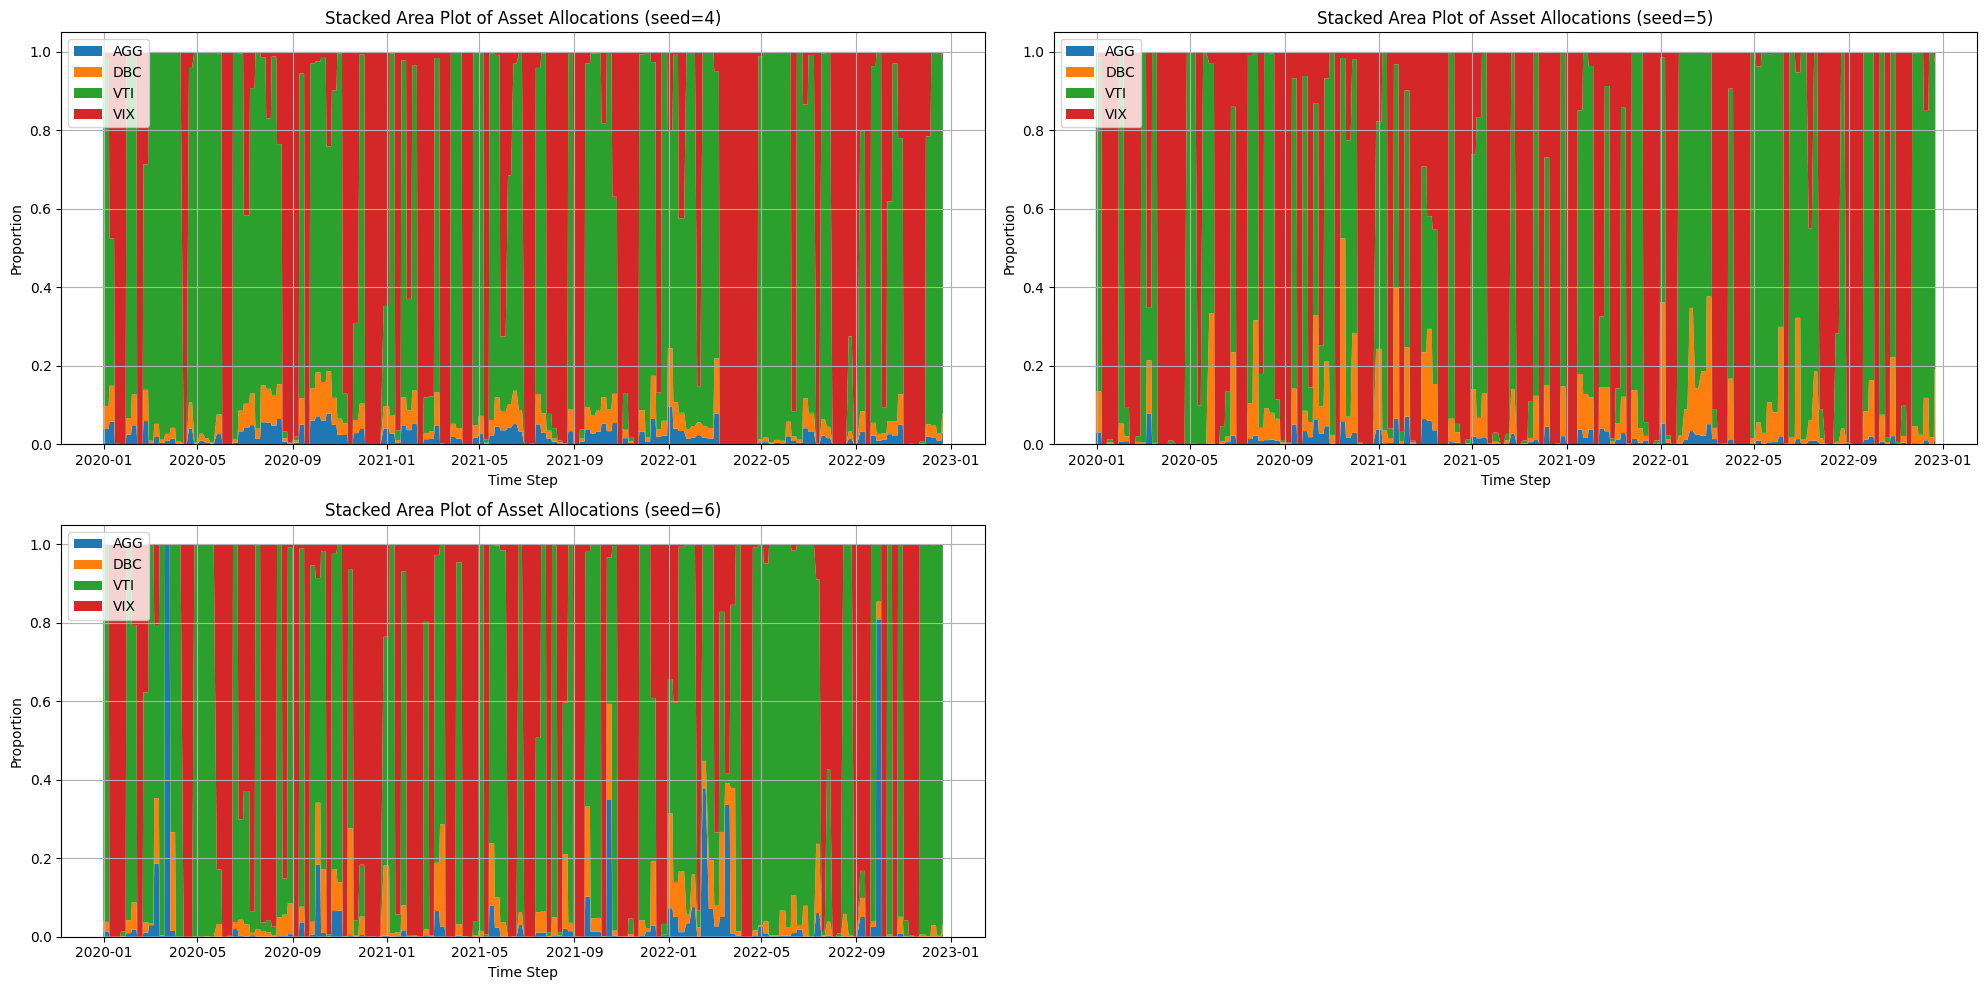

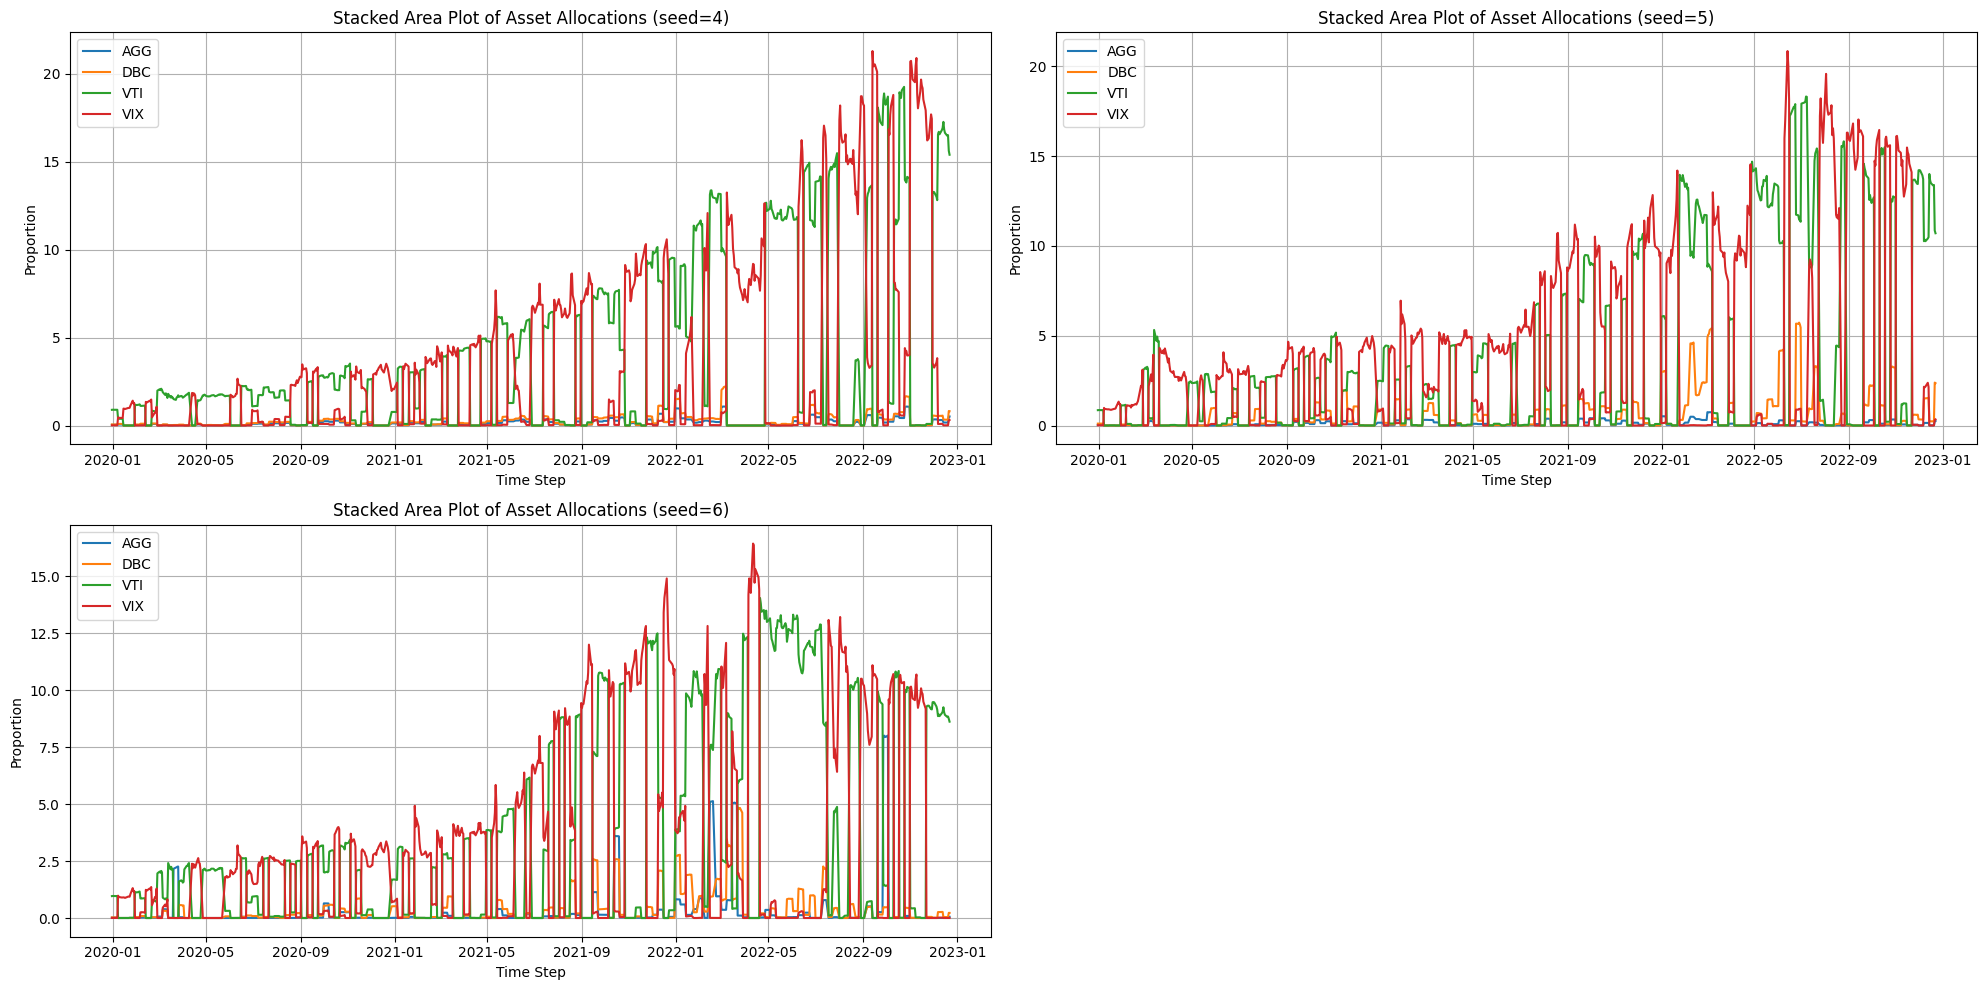

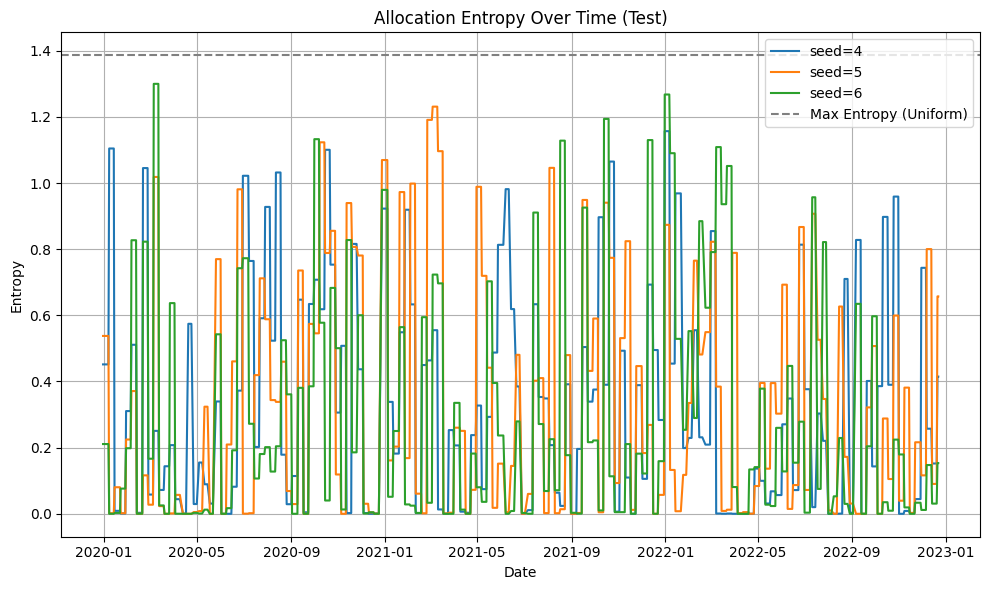

--------------------
Val RESULTS
--------------------


/tmp/ipykernel_395219/2067568222.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


expected_return sharpe_ratio max_drawdown mean_entropy mean_return  \
seed=4            2.62        0.121        0.269        0.413     0.00546   
seed=5            2.87        0.104        0.351         0.37     0.00661   
seed=6            2.21        0.101        0.404        0.345     0.00536   

       std_return  
seed=4     0.0451  
seed=5     0.0636  
seed=6      0.053

(285,)
(285,)
(285,)


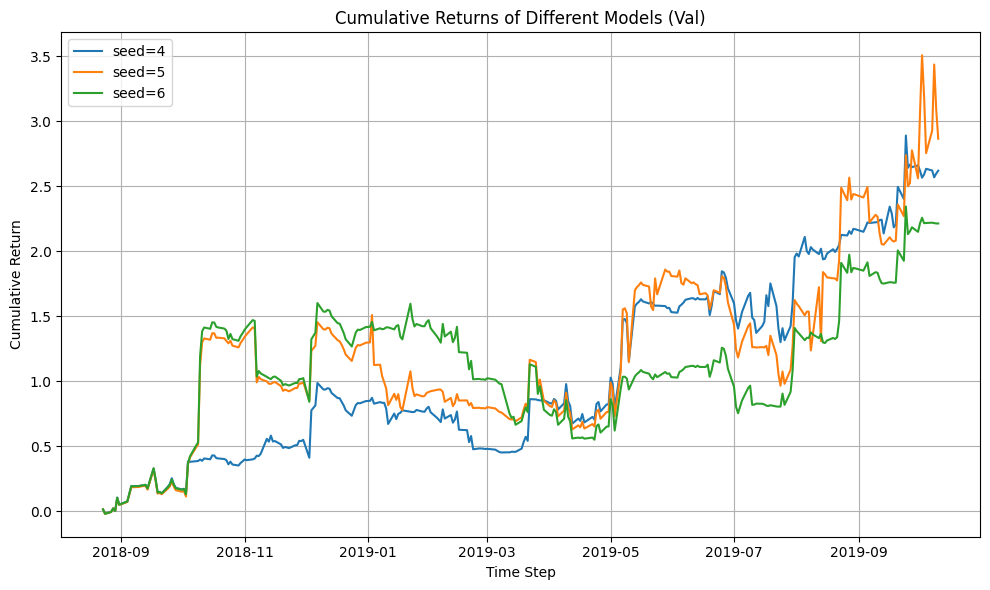

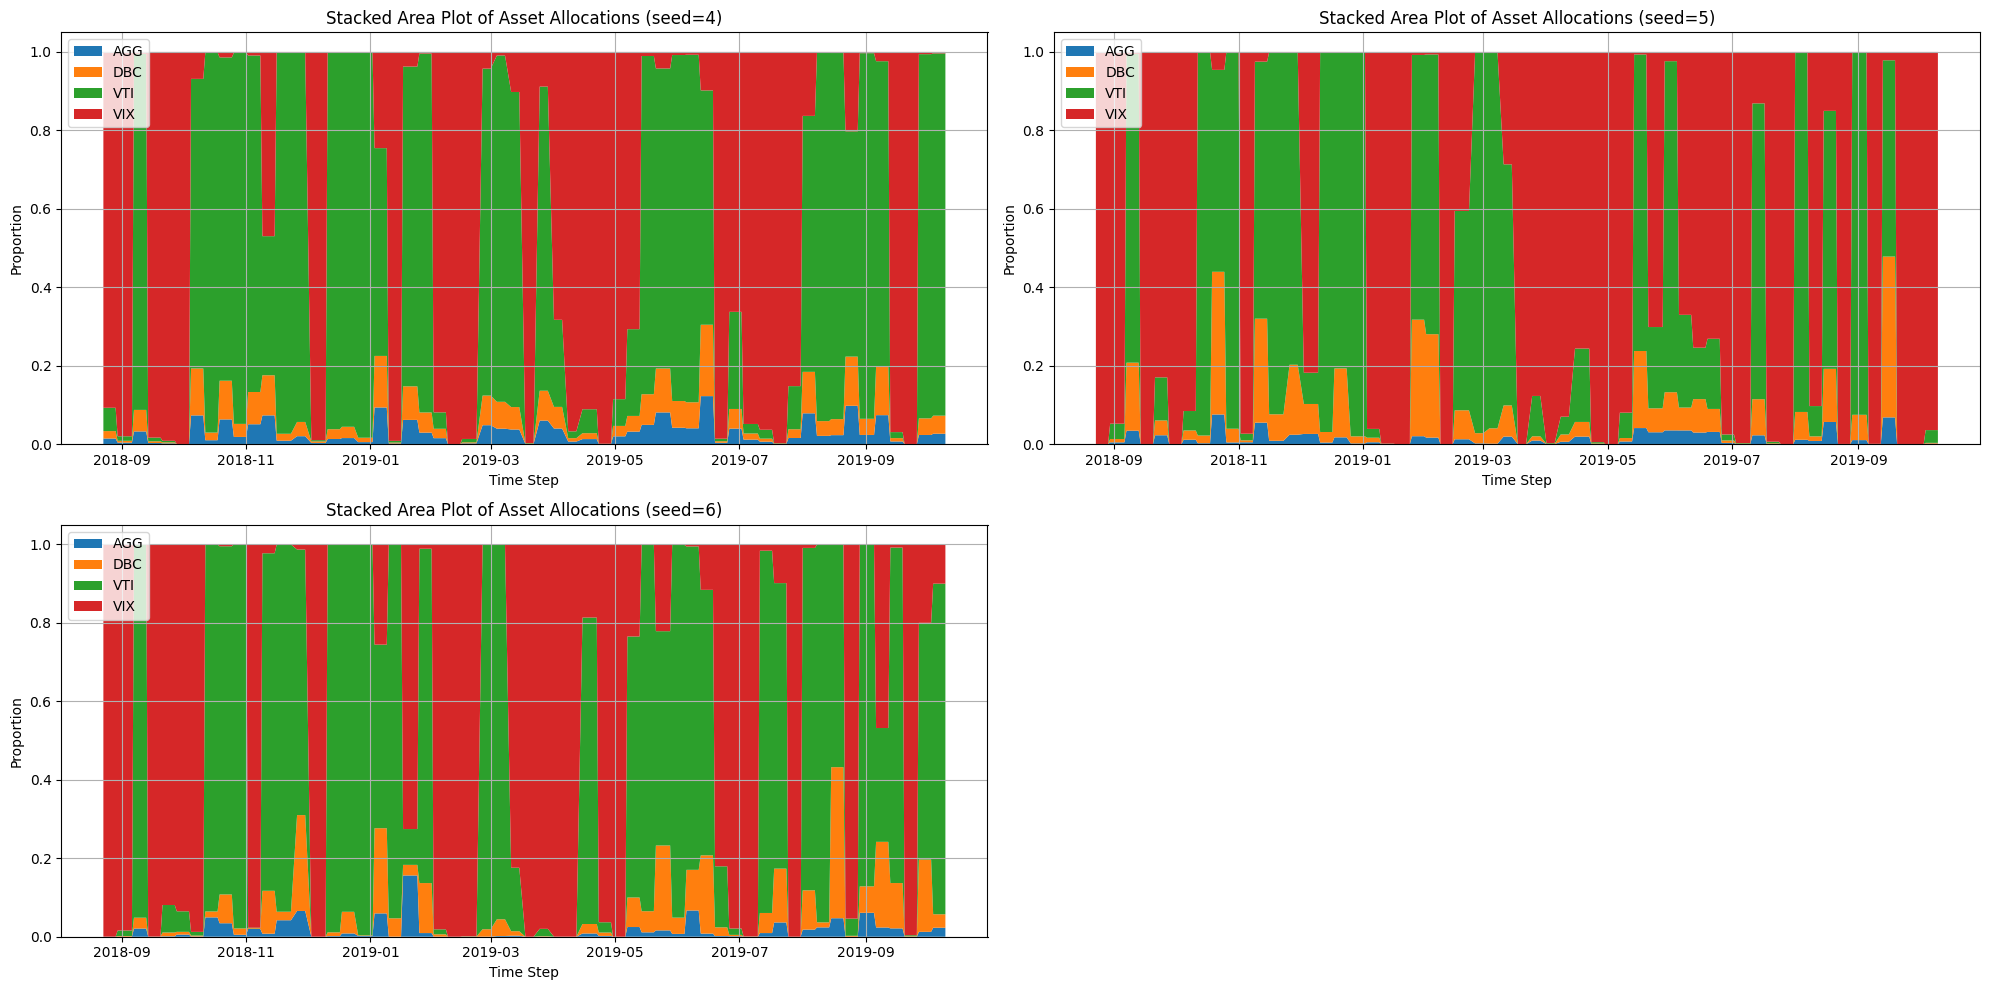

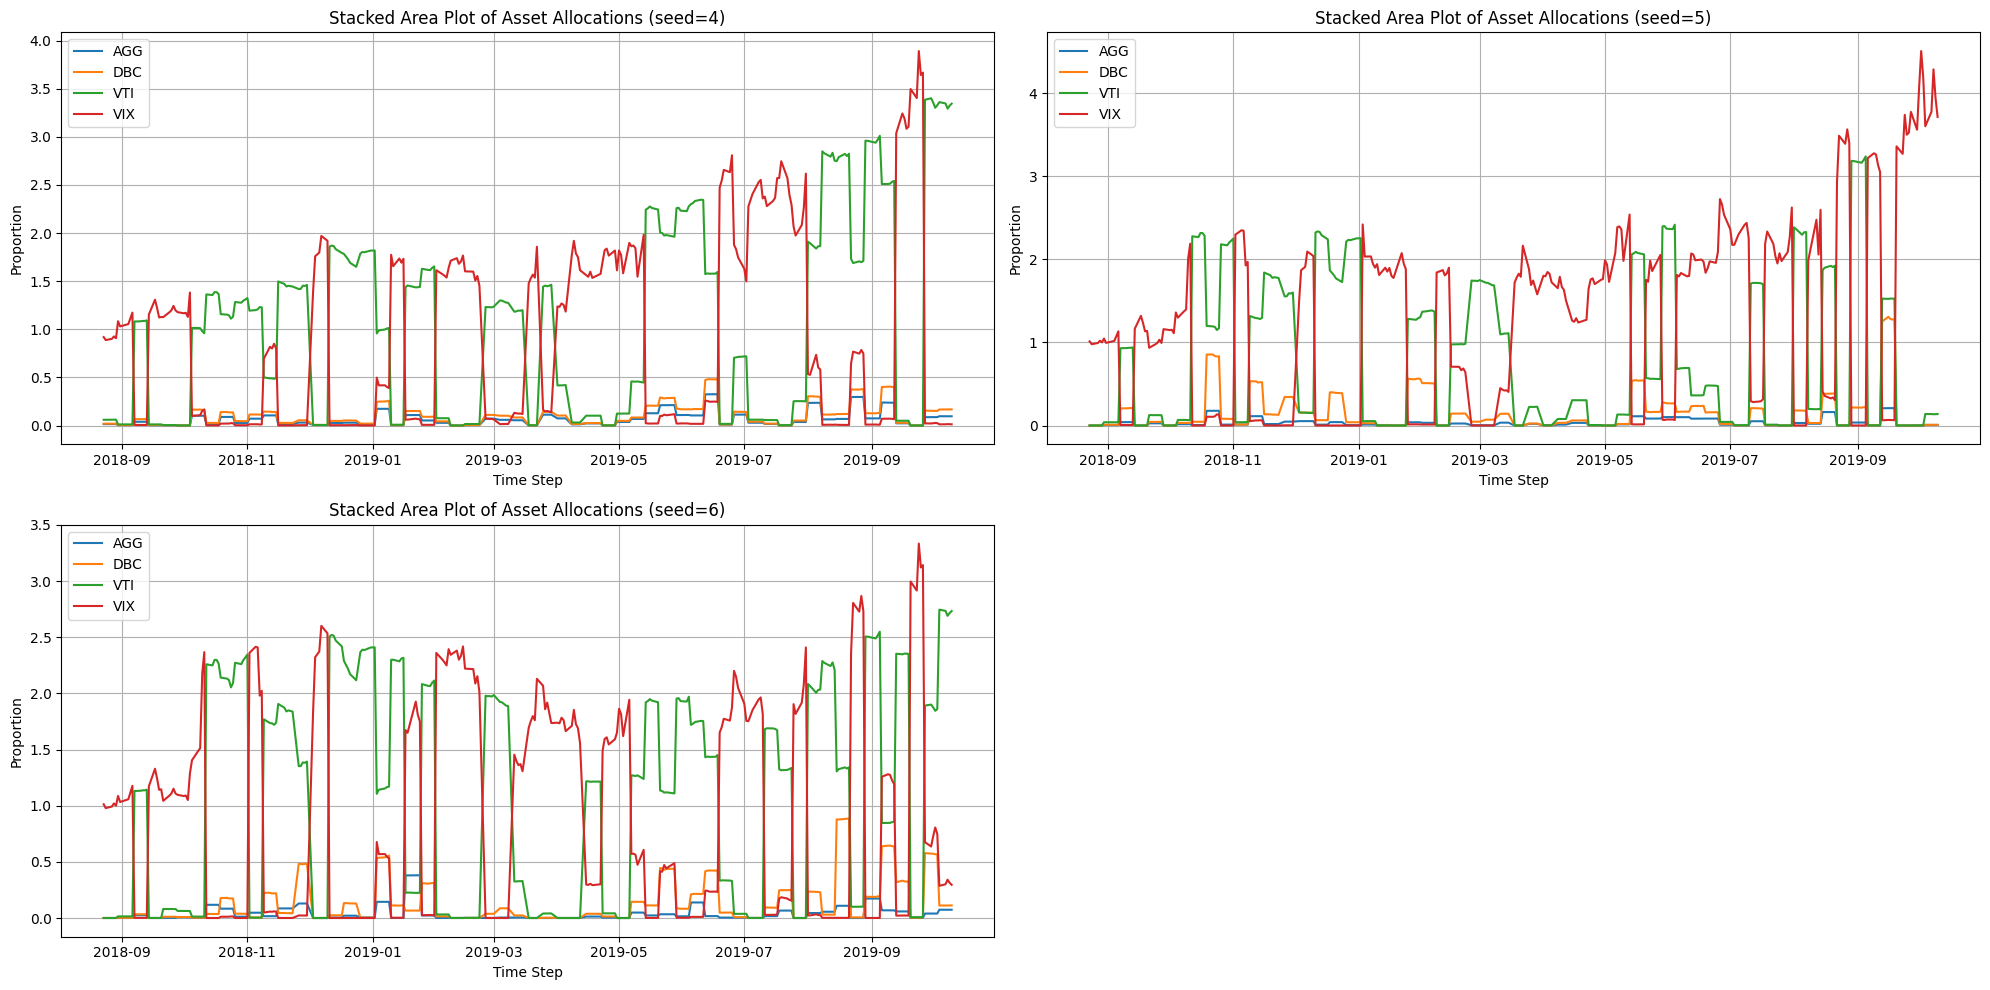

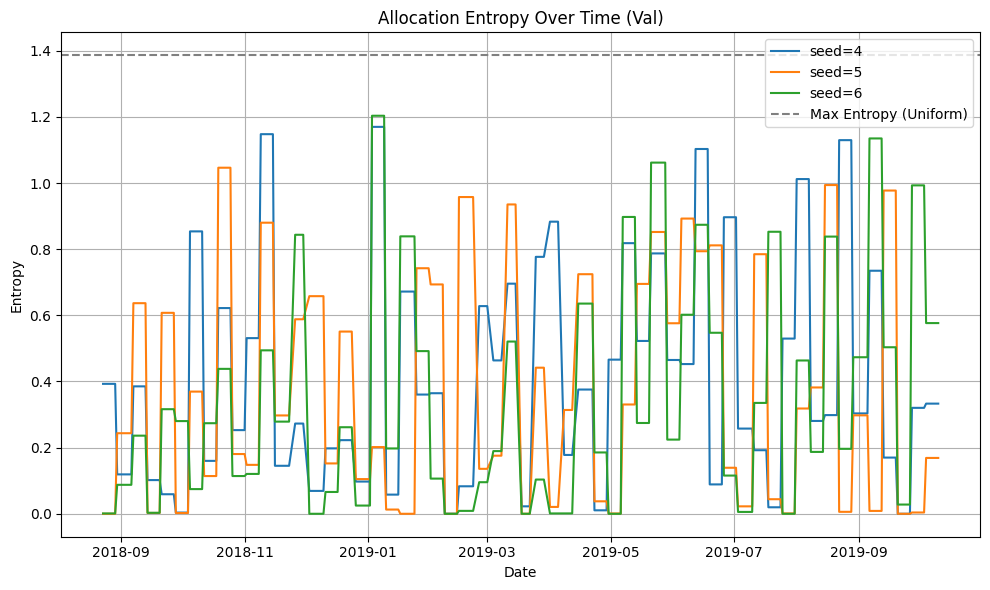

In [406]:
filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk]) for pk in params])}
display_train_results(filtered_experiements)
for dataset_key, dataset_idx in zip(["test", "val"], [test_idx, val_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(filtered_experiements, dataset_key, dataset_idx )

## MLP - Param Tuning

In [414]:
params_grids = [{
    "seed": [0,1,2],
    "epochs": [30],
    "lambda_entropy": [0.001, 0.01, 0.025, 0.05, 0.1],
    "model": ["MLP"],
    "learning_rate": [1e-3],
    "checkpoint_freq": [3],
    "rebalance_freq": [5],
}
]

experiment_path = "fyp3/experiments/standard_model/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

Loading fyp3/experiments/standard_model/seed=0,epochs=30,lambda_entropy=0.001,model=MLP,learning_rate=0.001,checkpoint_freq=3,rebalance_freq=5,checkpoint=3.pth
Loading fyp3/experiments/standard_model/seed=0,epochs=30,lambda_entropy=0.001,model=MLP,learning_rate=0.001,checkpoint_freq=3,rebalance_freq=5,checkpoint=6.pth
Loading fyp3/experiments/standard_model/seed=0,epochs=30,lambda_entropy=0.001,model=MLP,learning_rate=0.001,checkpoint_freq=3,rebalance_freq=5,checkpoint=9.pth
Loading fyp3/experiments/standard_model/seed=0,epochs=30,lambda_entropy=0.001,model=MLP,learning_rate=0.001,checkpoint_freq=3,rebalance_freq=5,checkpoint=12.pth
Loading fyp3/experiments/standard_model/seed=0,epochs=30,lambda_entropy=0.001,model=MLP,learning_rate=0.001,checkpoint_freq=3,rebalance_freq=5,checkpoint=15.pth
Loading fyp3/experiments/standard_model/seed=0,epochs=30,lambda_entropy=0.001,model=MLP,learning_rate=0.001,checkpoint_freq=3,rebalance_freq=5,checkpoint=18.pth
Loading fyp3/experiments/standard_mod

In [408]:
combined_df = pd.DataFrame({label_from_params(v["params"], experiments): v['params'] for k, v in experiments.items()}).T
params = list(combined_df.columns)
for df_name in ["val", "test"]:
    df  = pd.DataFrame({label_from_params(v["params"], experiments): v['results'][df_name]["metrics"] for k, v in experiments.items()}).T
    df = df.add_prefix(f'{df_name}_')
    combined_df = pd.concat([combined_df, df], axis=1)

params.remove("seed")
metric = "val_expected_return"
combined_df = combined_df.groupby(params)[metric].agg(lambda x: x.mean() if not x.isna().any() else np.nan).reset_index().dropna()

combined_df = combined_df.sort_values(metric, ascending=False).rename(columns={metric: f"mean_{metric}"})
display(combined_df)
best_params = combined_df[params].iloc[0].to_dict()
best_MLP_params = best_params
print(best_params)

epochs  lambda_entropy model  learning_rate  checkpoint_freq  \
14      30           0.010   MLP          0.001                3   
15      30           0.010   MLP          0.001                3   
13      30           0.010   MLP          0.001                3   
23      30           0.025   MLP          0.001                3   
12      30           0.010   MLP          0.001                3   
16      30           0.010   MLP          0.001                3   
11      30           0.010   MLP          0.001                3   
22      30           0.025   MLP          0.001                3   
3       30           0.001   MLP          0.001                3   
24      30           0.025   MLP          0.001                3   
21      30           0.025   MLP          0.001                3   
2       30           0.001   MLP          0.001                3   
25      30           0.025   MLP          0.001                3   
26      30           0.025   MLP          0.001                3   
31      30           0.050   MLP          0.001                3   
27      30           0.025   MLP          0.001                3   
32      30           0.050   MLP          0.001                3   
20      30           0.025   MLP          0.001                3   
1       30           0.001   MLP          0.001                3   
33      30           0.050   MLP          0.001                3   
30      30           0.050   MLP          0.001                3   
10      30           0.010   MLP          0.001                3   
36      30           0.050   MLP          0.001                3   
34      30           0.050   MLP          0.001                3   
0       30           0.001   MLP          0.001                3   
49      30           0.100   MLP          0.001                3   
40      30           0.100   MLP          0.001                3   
35      30           0.050   MLP          0.001                3   
43      30           0.100   MLP          0.001                3   
44      30           0.100   MLP          0.001                3   
47      30           0.100   MLP          0.001                3   
45      30           0.100   MLP          0.001                3   
46      30           0.100   MLP          0.001                3   
41      30           0.100   MLP          0.001                3   
48      30           0.100   MLP          0.001                3   
38      30           0.050   MLP          0.001                3   
37      30           0.050   MLP          0.001                3   
42      30           0.100   MLP          0.001                3   
39      30           0.050   MLP          0.001                3   

    rebalance_freq  checkpoint  mean_val_expected_return  
14               5          15                  1.904696  
15               5          18                  1.755206  
13               5          12                  1.599724  
23               5          12                  1.395470  
12               5           9                  1.224557  
16               5          21                  1.128883  
11               5           6                  1.085107  
22               5           9                  1.033810  
3                5          12                  1.012612  
24               5          15                  1.001026  
21               5           6                  0.928226  
2                5           9                  0.925107  
25               5          18                  0.823567  
26               5          21                  0.755938  
31               5           6                  0.737421  
27               5          24                  0.731259  
32               5           9                  0.726154  
20               5           3                  0.685987  
1                5           6                  0.598459  
33               5          12                  0.577357  
30               5           3              

{'epochs': 30, 'lambda_entropy': 0.01, 'model': 'MLP', 'learning_rate': 0.001, 'checkpoint_freq': 3, 'rebalance_freq': 5, 'checkpoint': 15}


/tmp/ipykernel_395219/1706481994.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


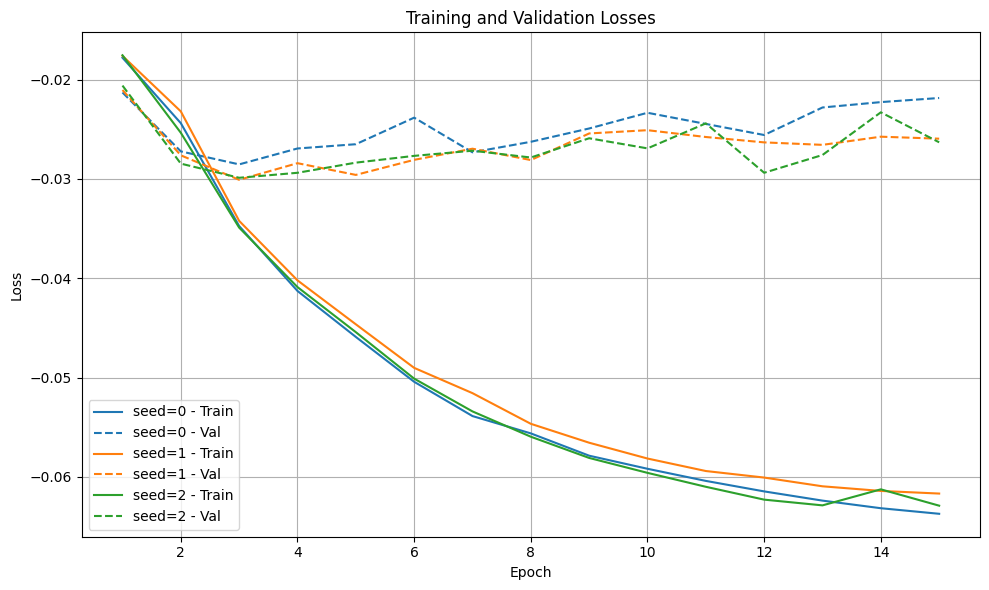

--------------------
Test RESULTS
--------------------


/tmp/ipykernel_395219/1706481994.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


expected_return sharpe_ratio max_drawdown mean_entropy mean_return  \
seed=0            2.24       0.0542        0.475        0.718     0.00272   
seed=1            6.59       0.0756        0.515        0.744     0.00392   
seed=2            12.8       0.0857        0.574         0.63     0.00507   

       std_return  
seed=0     0.0502  
seed=1     0.0519  
seed=2     0.0591

(752,)
(752,)
(752,)


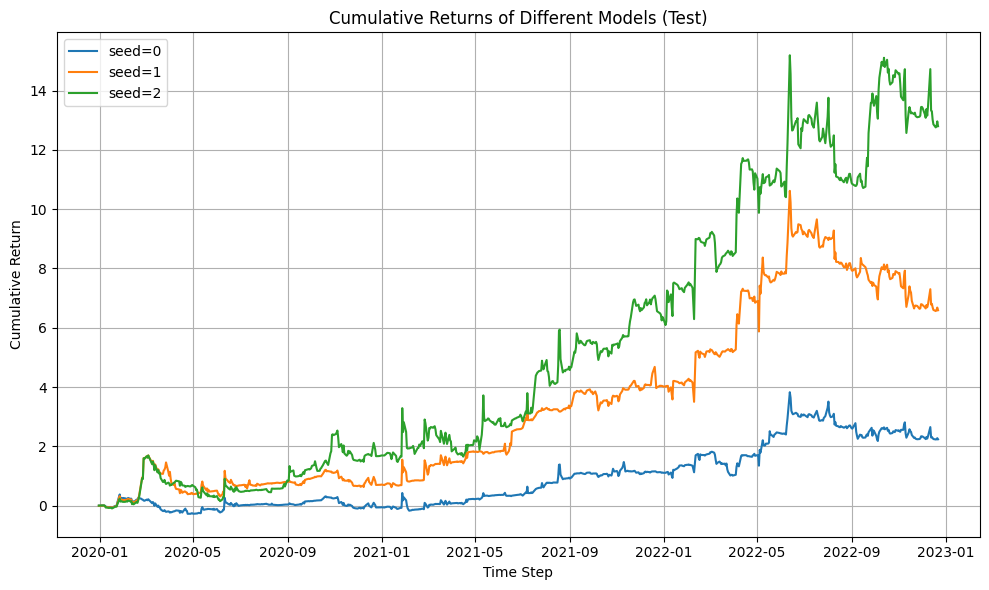

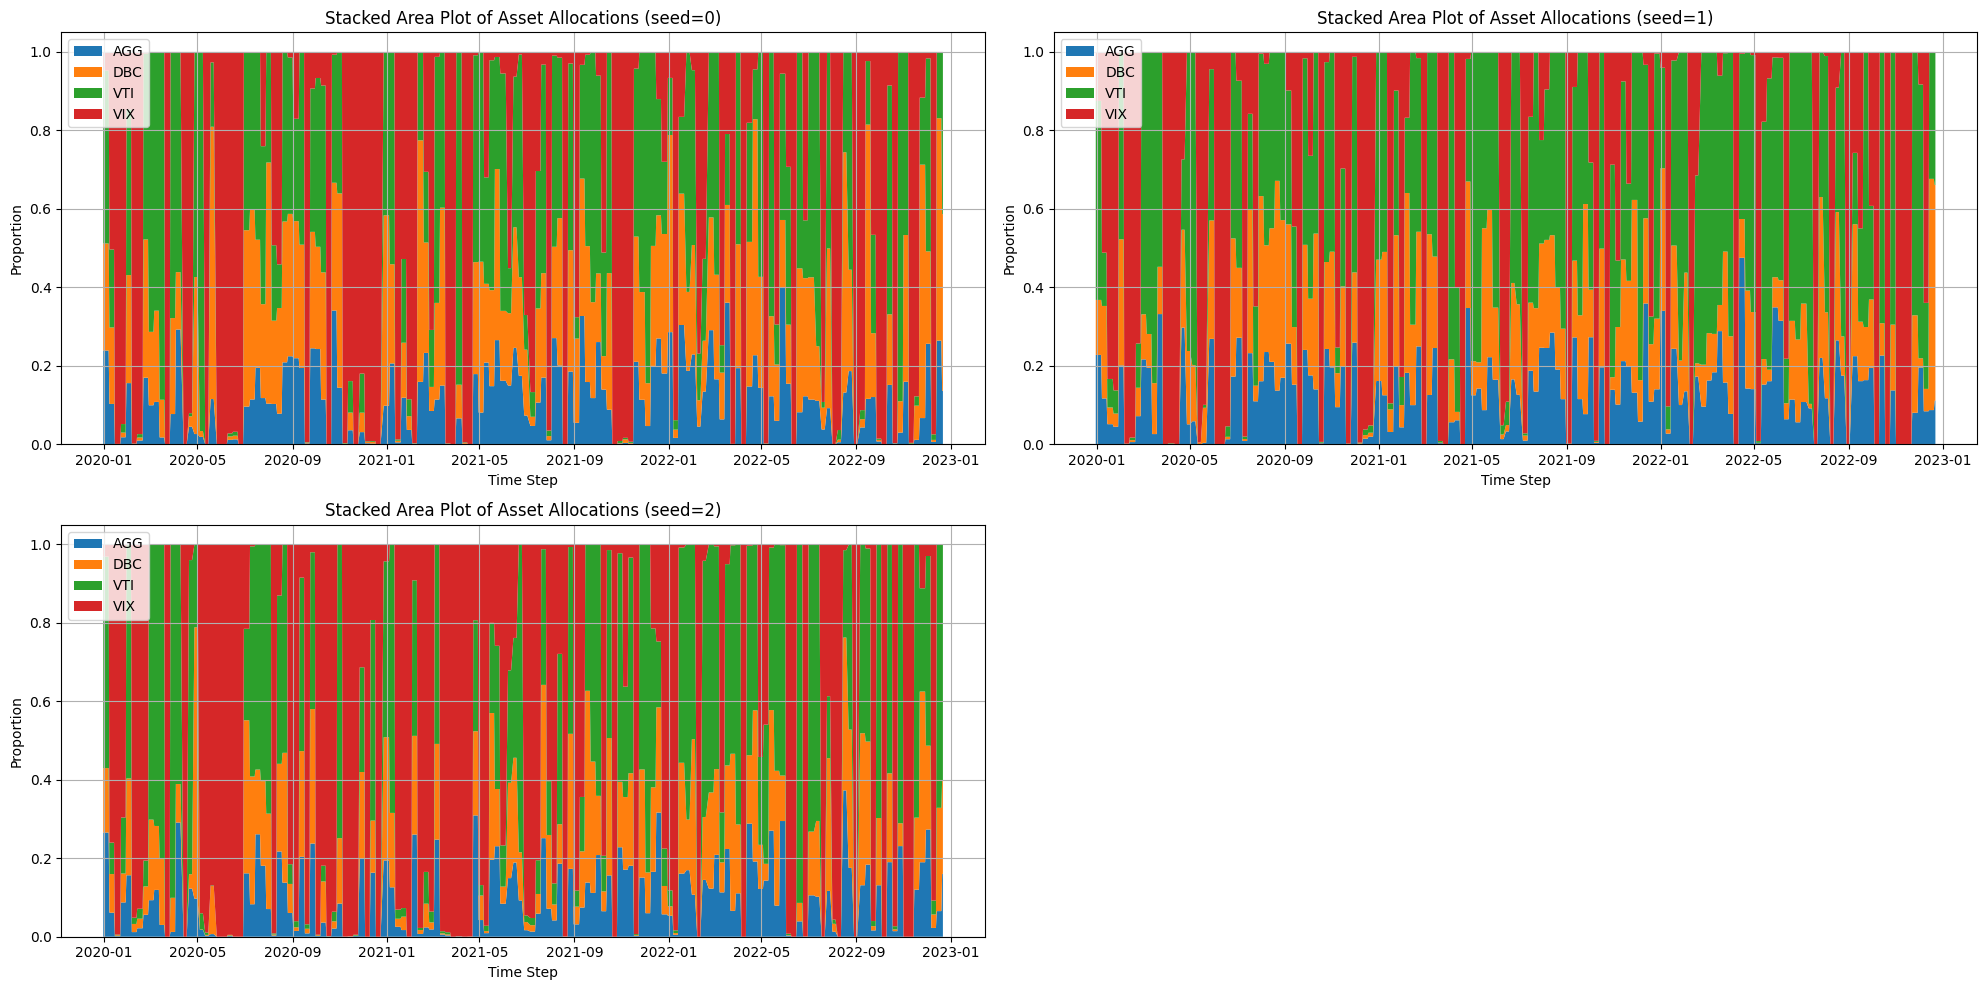

--------------------
Val RESULTS
--------------------


/tmp/ipykernel_395219/1706481994.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


expected_return sharpe_ratio max_drawdown mean_entropy mean_return  \
seed=0            2.87        0.115        0.347        0.772     0.00601   
seed=1            1.13       0.0781        0.331        0.785     0.00369   
seed=2            1.72       0.0993         0.41        0.843     0.00437   

       std_return  
seed=0     0.0524  
seed=1     0.0473  
seed=2      0.044

(285,)
(285,)
(285,)


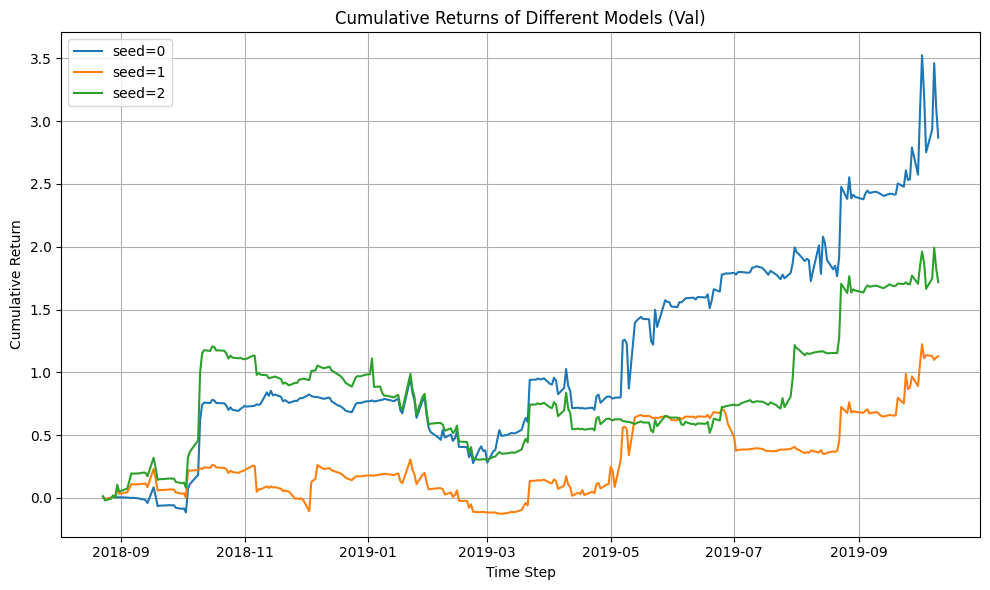

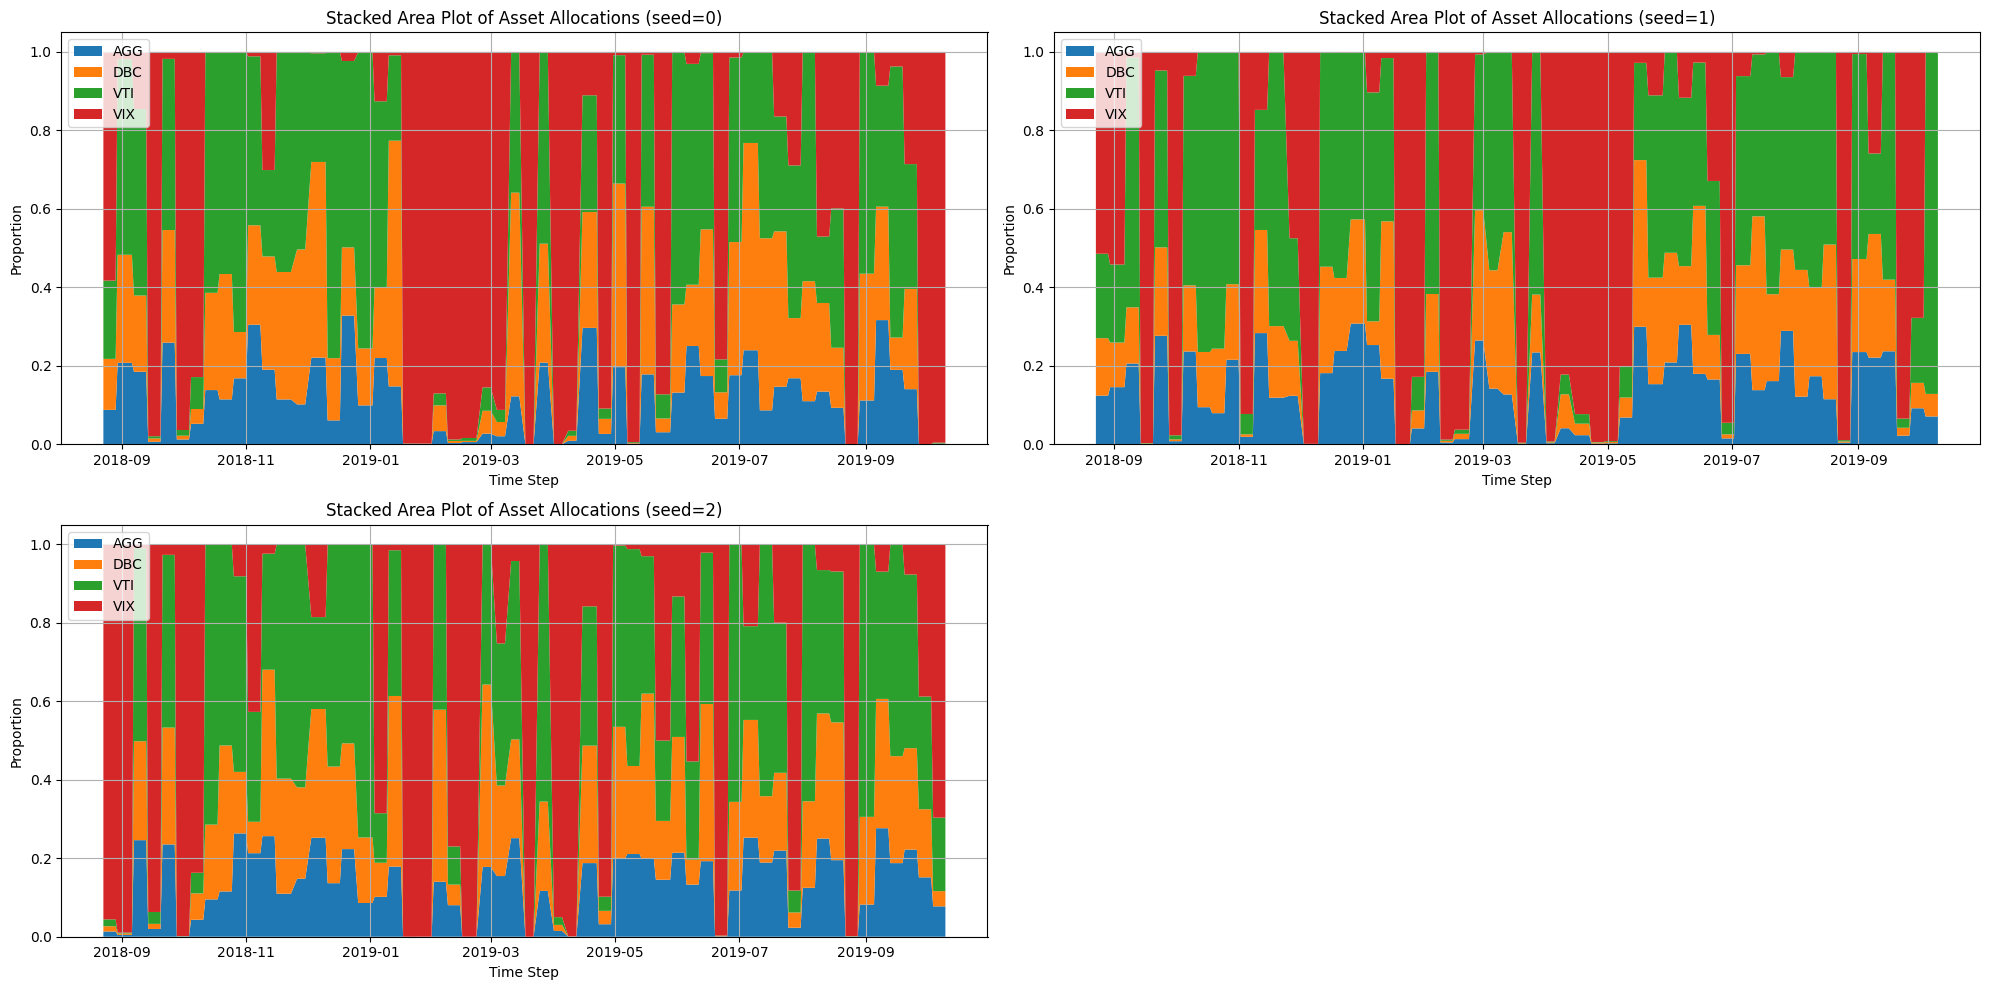

In [415]:
filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk]) for pk in params])}
display_train_results(filtered_experiements)
for dataset_key, dataset_idx in zip(["test", "val"], [test_idx, val_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(filtered_experiements, dataset_key, dataset_idx )

## LSTM Hyperparameter tuning

In [452]:
params_grids = [{
    "seed": [0, 20],
    "epochs": [100],
    "lambda_entropy": [0.025],
    "model": ["LSTM"],
    "lstm_layers" : [4],
    "lstm_hidden_layers": [1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "checkpoint_freq": [8]
}
]

experiment_path = "fyp3/experiments/standard_model/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

Loading fyp3/experiments/standard_model/seed=0,epochs=100,lambda_entropy=0.025,model=LSTM,lstm_layers=4,lstm_hidden_layers=1,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=8,checkpoint=8.pth
Loading fyp3/experiments/standard_model/seed=0,epochs=100,lambda_entropy=0.025,model=LSTM,lstm_layers=4,lstm_hidden_layers=1,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=8,checkpoint=16.pth
Loading fyp3/experiments/standard_model/seed=0,epochs=100,lambda_entropy=0.025,model=LSTM,lstm_layers=4,lstm_hidden_layers=1,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=8,checkpoint=24.pth
Loading fyp3/experiments/standard_model/seed=0,epochs=100,lambda_entropy=0.025,model=LSTM,lstm_layers=4,lstm_hidden_layers=1,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=8,checkpoint=32.pth
Loading fyp3/experiments/standard_model/seed=0,epochs=100,lambda_entropy=0.025,model=LSTM,lstm_layers=4,lstm_hidden_layers=1,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=8,checkpoint=40.pth
Loading fyp

In [453]:
combined_df = pd.DataFrame({label_from_params(v["params"], experiments): v['params'] for k, v in experiments.items()}).T
params = list(combined_df.columns)
for df_name in ["val", "test"]:
    df  = pd.DataFrame({label_from_params(v["params"], experiments): v['results'][df_name]["metrics"] for k, v in experiments.items()}).T
    df = df.add_prefix(f'{df_name}_')
    combined_df = pd.concat([combined_df, df], axis=1)

params.remove("seed")
metric = "val_expected_return"
combined_df = combined_df.groupby(params)[metric].agg(lambda x: x.mean() if not x.isna().any() else np.nan).reset_index().dropna()

combined_df = combined_df.sort_values(metric, ascending=False).rename(columns={metric: f"mean_{metric}"})
display(combined_df)
best_params = combined_df[params].iloc[0].to_dict()
best_lstm_params = best_params
print(best_params)

epochs  lambda_entropy model  lstm_layers  lstm_hidden_layers  \
4      100           0.025  LSTM            4                   1   
6      100           0.025  LSTM            4                   1   
5      100           0.025  LSTM            4                   1   
7      100           0.025  LSTM            4                   1   
9      100           0.025  LSTM            4                   1   
8      100           0.025  LSTM            4                   1   
3      100           0.025  LSTM            4                   1   
10     100           0.025  LSTM            4                   1   
11     100           0.025  LSTM            4                   1   
12     100           0.025  LSTM            4                   1   
2      100           0.025  LSTM            4                   1   
1      100           0.025  LSTM            4                   1   
0      100           0.025  LSTM            4                   1   

    learning_rate  rebalance_freq  checkpoint_freq  checkpoint  \
4           0.001               5                8          40   
6           0.001               5                8          56   
5           0.001               5                8          48   
7           0.001               5                8          64   
9           0.001               5                8          80   
8           0.001               5                8          72   
3           0.001               5                8          32   
10          0.001               5                8          88   
11          0.001               5                8          96   
12          0.001               5                8         100   
2           0.001               5                8          24   
1           0.001               5                8          16   
0           0.001               5                8           8   

    mean_val_expected_return  
4                   0.873957  
6                   0.850482  
5                   0.842399  
7                   0.840905  
9                   0.823722  
8                   0.821558  
3                   0.800814  
10                  0.771508  
11                  0.758694  
12                  0.748540  
2                   0.619842  
1                   0.565365  
0                   0.463291

{'epochs': 100, 'lambda_entropy': 0.025, 'model': 'LSTM', 'lstm_layers': 4, 'lstm_hidden_layers': 1, 'learning_rate': 0.001, 'rebalance_freq': 5, 'checkpoint_freq': 8, 'checkpoint': 40}


/tmp/ipykernel_395219/1706481994.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


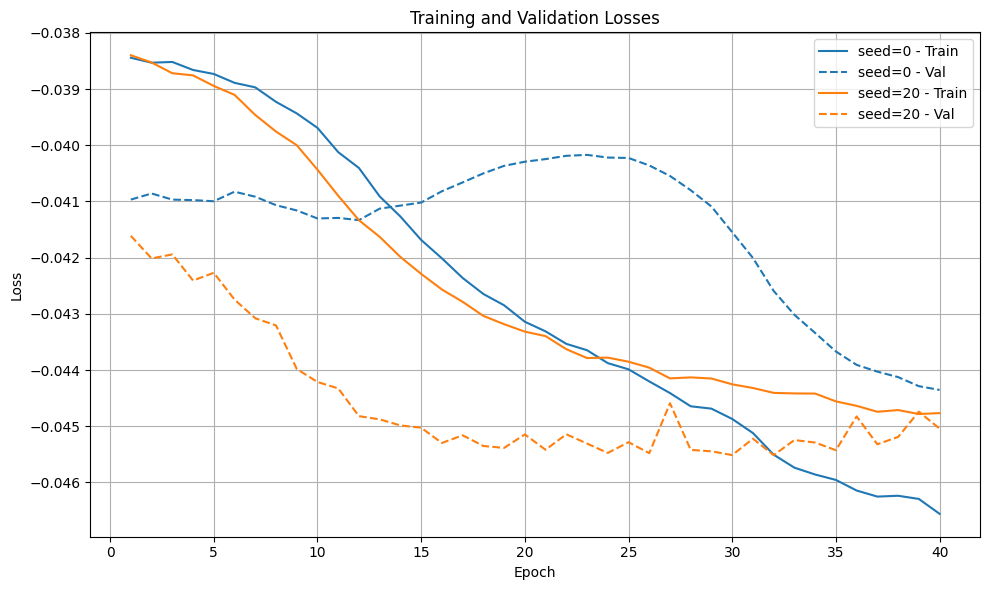

--------------------
Test RESULTS
--------------------


/tmp/ipykernel_395219/1706481994.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


expected_return sharpe_ratio max_drawdown mean_entropy mean_return  \
seed=0             6.94       0.0864        0.333         1.15     0.00364   
seed=20               9       0.0952        0.334         1.18     0.00389   

        std_return  
seed=0      0.0421  
seed=20     0.0409

(752,)
(752,)


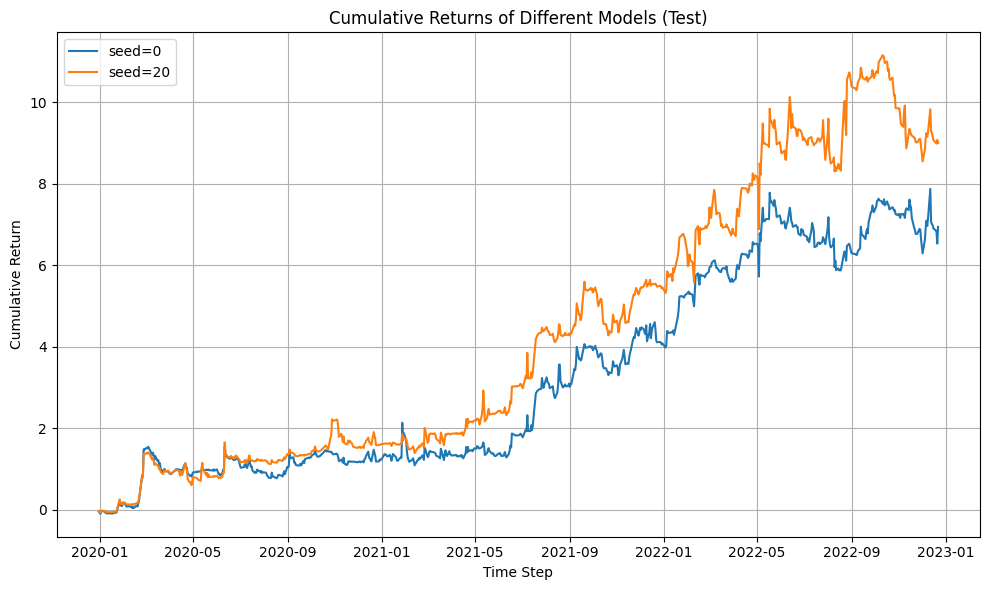

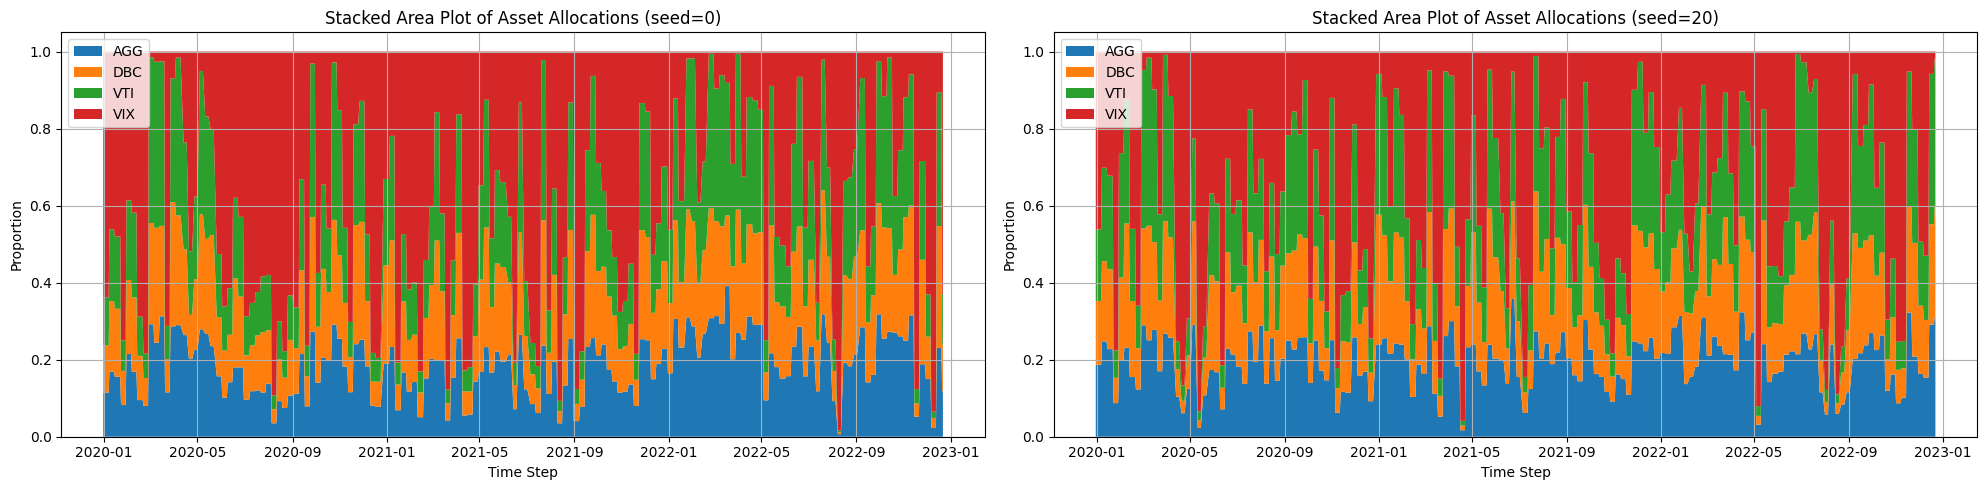

--------------------
Val RESULTS
--------------------


/tmp/ipykernel_395219/1706481994.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


expected_return sharpe_ratio max_drawdown mean_entropy mean_return  \
seed=0            0.584       0.0624        0.259         1.13     0.00218   
seed=20            1.16       0.0939        0.259         1.16     0.00331   

        std_return  
seed=0       0.035  
seed=20     0.0353

(285,)
(285,)


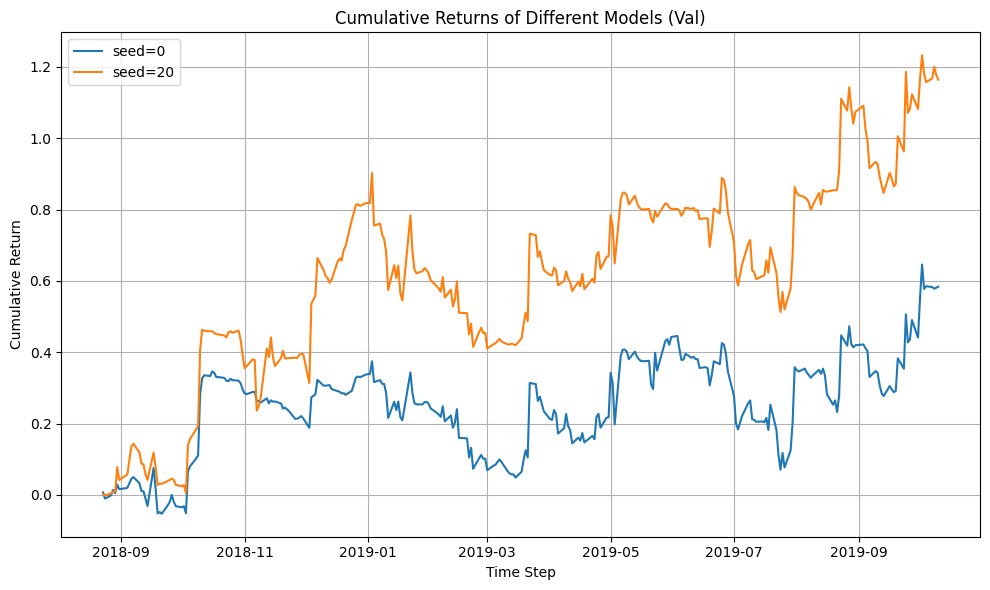

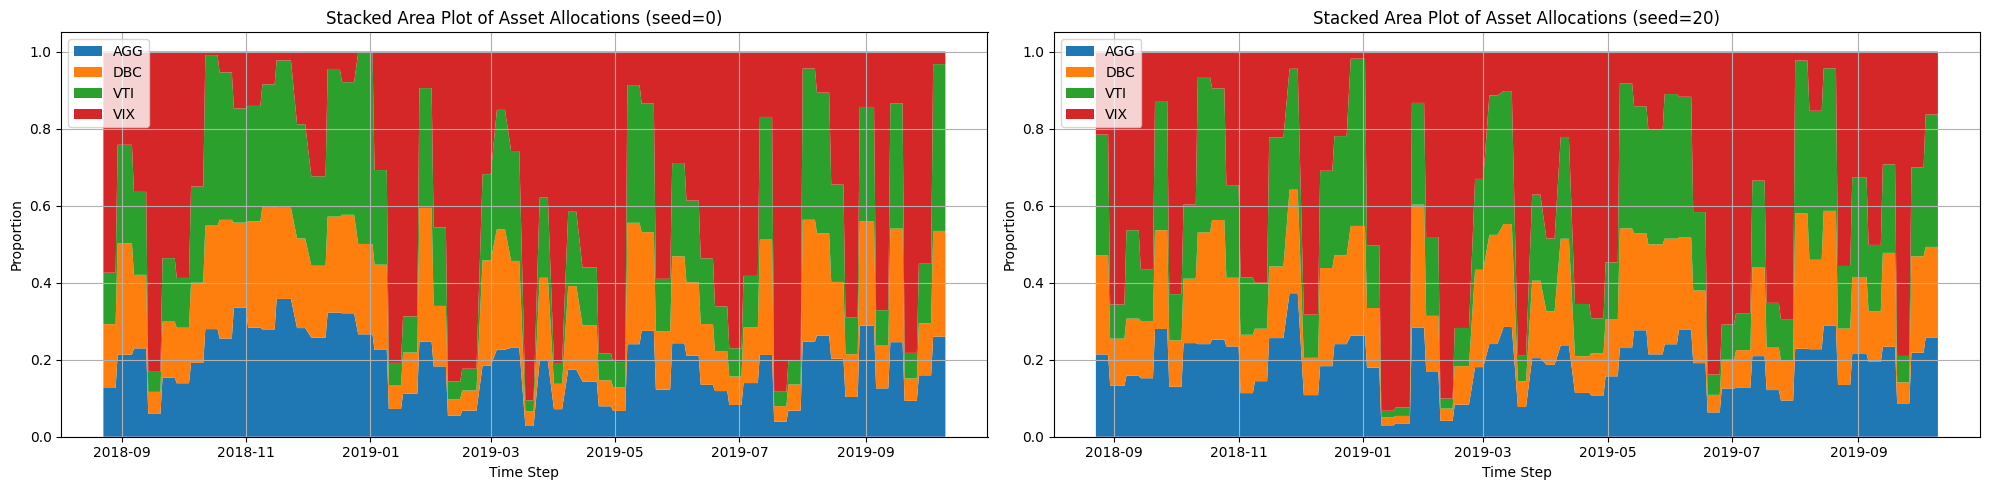

In [454]:
filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk]) for pk in params])}
display_train_results(filtered_experiements)
for dataset_key, dataset_idx in zip(["test", "val"], [test_idx, val_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(filtered_experiements, dataset_key, dataset_idx )

## Transformer Hyperparameter tuning



In [458]:
params_grids = [{
    "seed": [0, 1, 2],
    "epochs": [20],
    "lambda_entropy": [0.025],
    "model": ["Transformer"],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "checkpoint_freq": [3]
}
]

experiment_path = "fyp3/experiments/standard_model/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

Loading fyp3/experiments/standard_model/seed=0,epochs=20,lambda_entropy=0.025,model=Transformer,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=3,checkpoint=3.pth
Loading fyp3/experiments/standard_model/seed=0,epochs=20,lambda_entropy=0.025,model=Transformer,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=3,checkpoint=6.pth
Loading fyp3/experiments/standard_model/seed=0,epochs=20,lambda_entropy=0.025,model=Transformer,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=3,checkpoint=9.pth
Loading fyp3/experiments/standard_model/seed=0,epochs=20,lambda_entropy=0.025,model=Transformer,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=3,checkpoint=12.pth
Loading fyp3/experiments/standard_model/seed=0,epochs=20,lambda_entropy=0.025,model=Transformer,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=3,checkpoint=15.pth
Loading fyp3/experiments/standard_model/seed=0,epochs=20,lambda_entropy=0.025,model=Transformer,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=3,checkpo

In [459]:
combined_df = pd.DataFrame({label_from_params(v["params"], experiments): v['params'] for k, v in experiments.items()}).T
params = list(combined_df.columns)
for df_name in ["val", "test"]:
    df  = pd.DataFrame({label_from_params(v["params"], experiments): v['results'][df_name]["metrics"] for k, v in experiments.items()}).T
    df = df.add_prefix(f'{df_name}_')
    combined_df = pd.concat([combined_df, df], axis=1)

params.remove("seed")
metric = "val_expected_return"
combined_df = combined_df.groupby(params)[metric].agg(lambda x: x.mean() if not x.isna().any() else np.nan).reset_index().dropna()

combined_df = combined_df.sort_values(metric, ascending=False).rename(columns={metric: f"mean_{metric}"})
display(combined_df)
best_params = combined_df[params].iloc[0].to_dict()
best_transformer_params = best_params
print(best_params)

epochs  lambda_entropy        model  learning_rate  rebalance_freq  \
5      20           0.025  Transformer          0.001               5   
6      20           0.025  Transformer          0.001               5   
4      20           0.025  Transformer          0.001               5   
3      20           0.025  Transformer          0.001               5   
2      20           0.025  Transformer          0.001               5   
0      20           0.025  Transformer          0.001               5   
1      20           0.025  Transformer          0.001               5   

   checkpoint_freq  checkpoint  mean_val_expected_return  
5                3          18                  1.300279  
6                3          20                  1.271512  
4                3          15                  1.120548  
3                3          12                  0.900923  
2                3           9                  0.654646  
0                3           3                  0.561570  
1                3           6                  0.512001

{'epochs': 20, 'lambda_entropy': 0.025, 'model': 'Transformer', 'learning_rate': 0.001, 'rebalance_freq': 5, 'checkpoint_freq': 3, 'checkpoint': 18}


/tmp/ipykernel_395219/1706481994.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


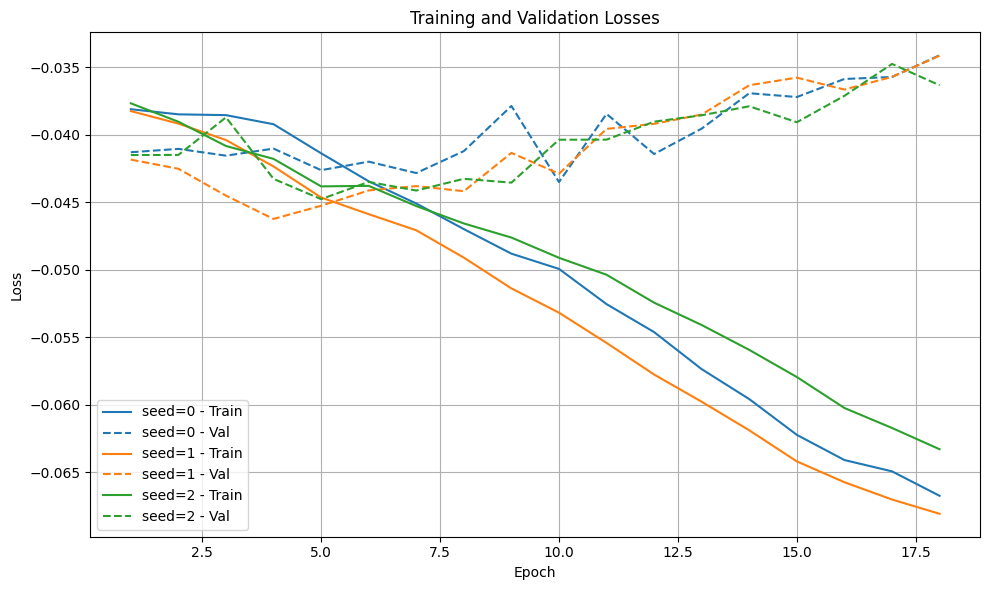

--------------------
Test RESULTS
--------------------


/tmp/ipykernel_395219/1706481994.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


expected_return sharpe_ratio max_drawdown mean_entropy mean_return  \
seed=0            2.47       0.0608        0.314         1.01     0.00234   
seed=1           0.225       0.0261        0.425         0.97     0.00101   
seed=2            4.35       0.0793        0.357         1.04     0.00285   

       std_return  
seed=0     0.0386  
seed=1     0.0387  
seed=2     0.0359

(752,)
(752,)
(752,)


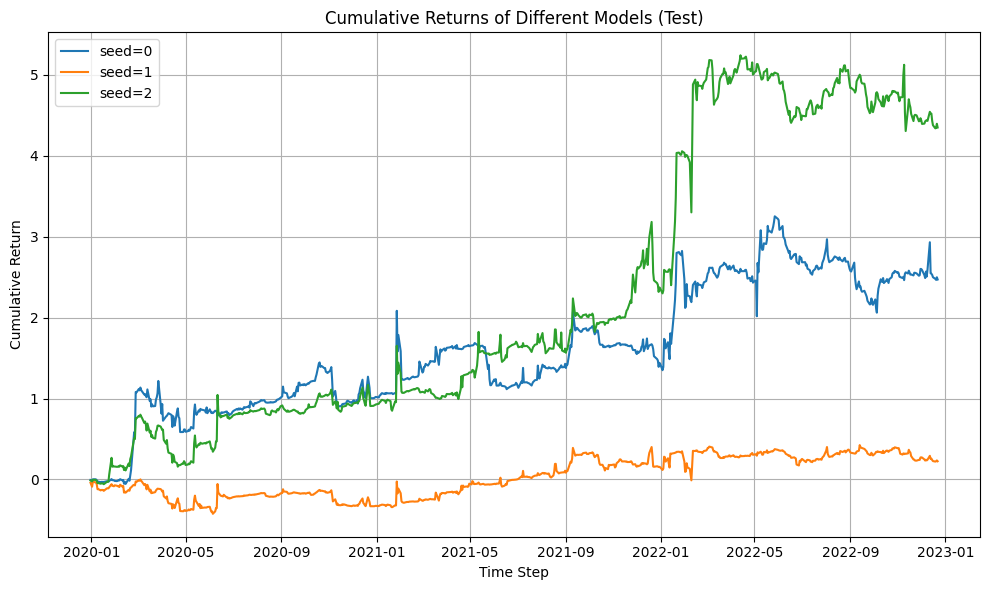

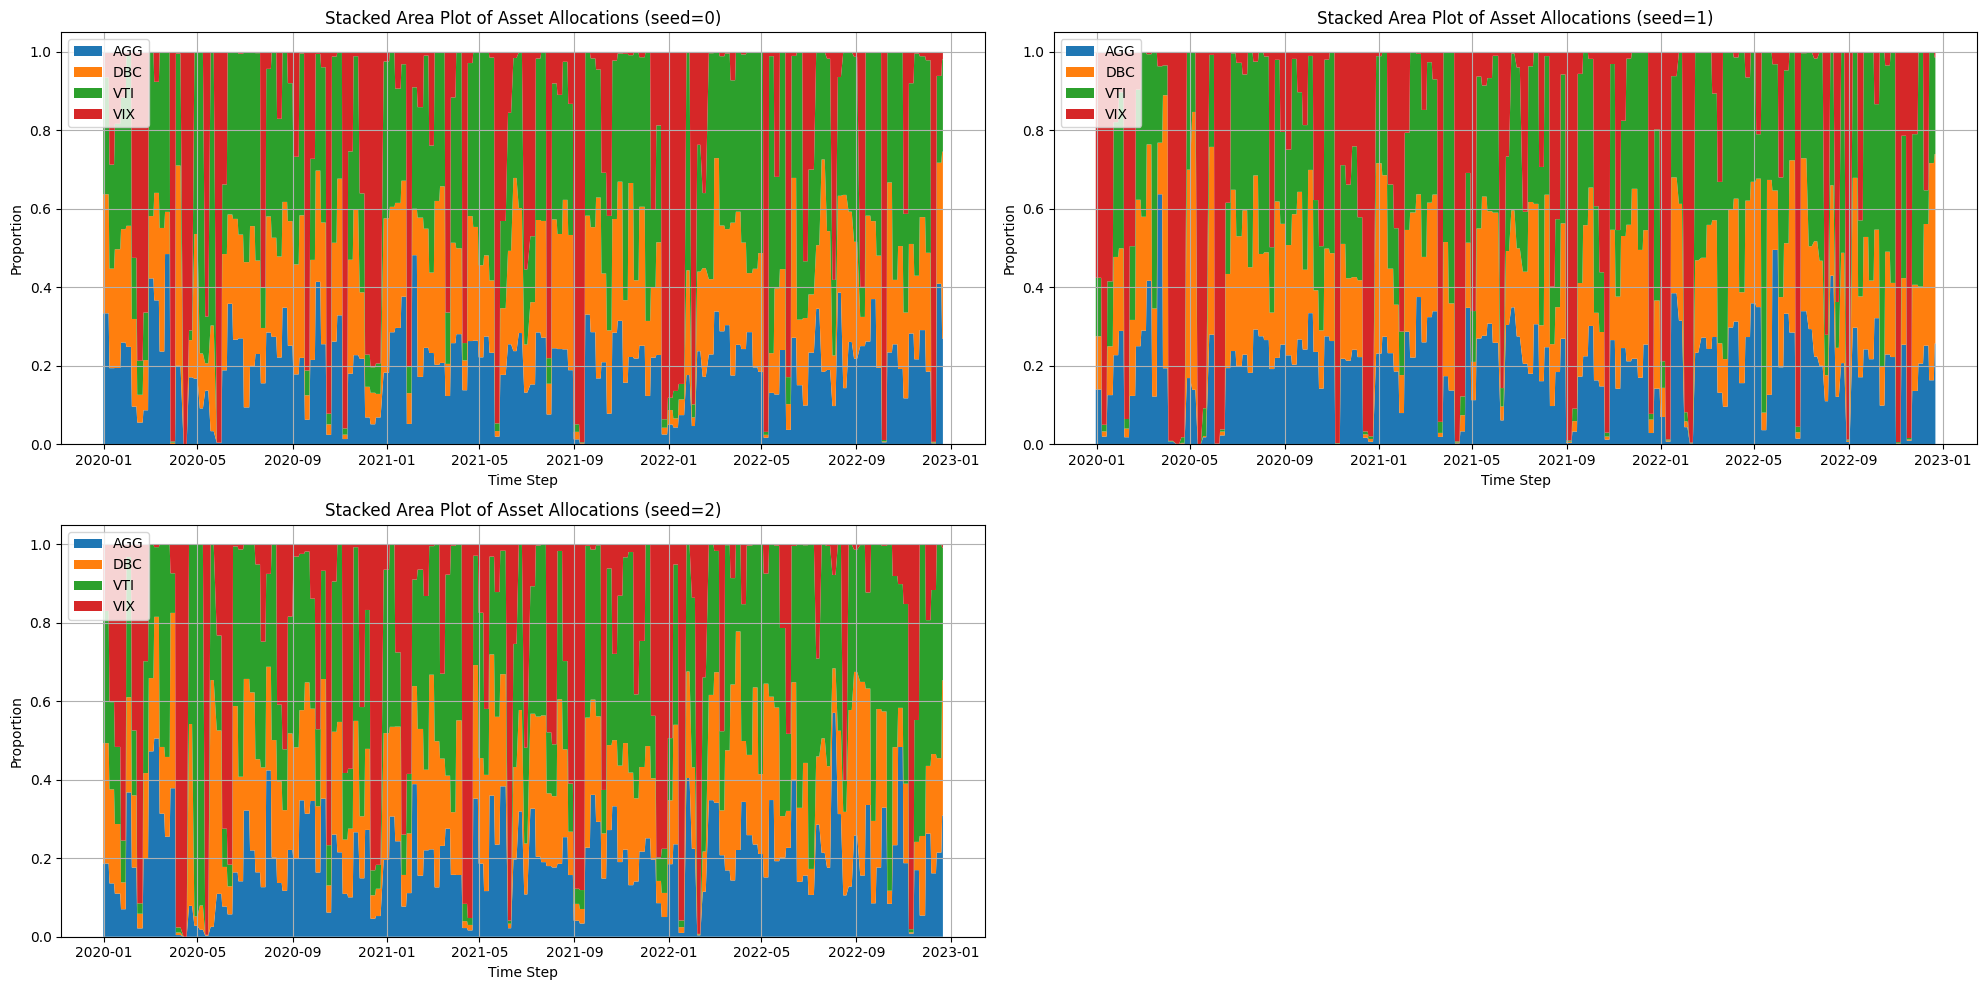

--------------------
Val RESULTS
--------------------


/tmp/ipykernel_395219/1706481994.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


expected_return sharpe_ratio max_drawdown mean_entropy mean_return  \
seed=0            1.55        0.121        0.191         1.09     0.00376   
seed=1            1.45       0.0973         0.36         1.03     0.00392   
seed=2           0.905       0.0822        0.313         1.02     0.00279   

       std_return  
seed=0     0.0311  
seed=1     0.0403  
seed=2     0.0339

(285,)
(285,)
(285,)


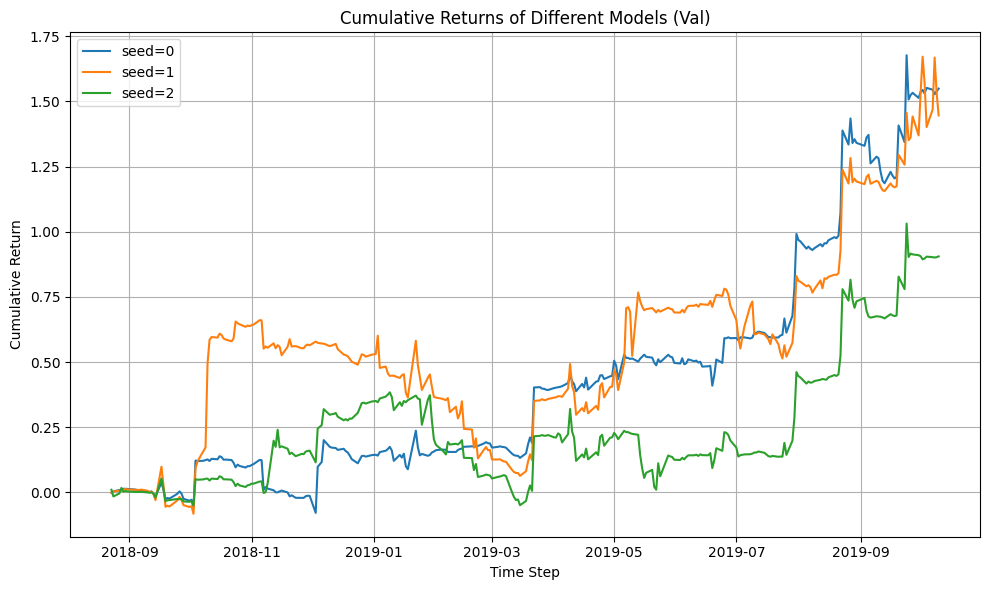

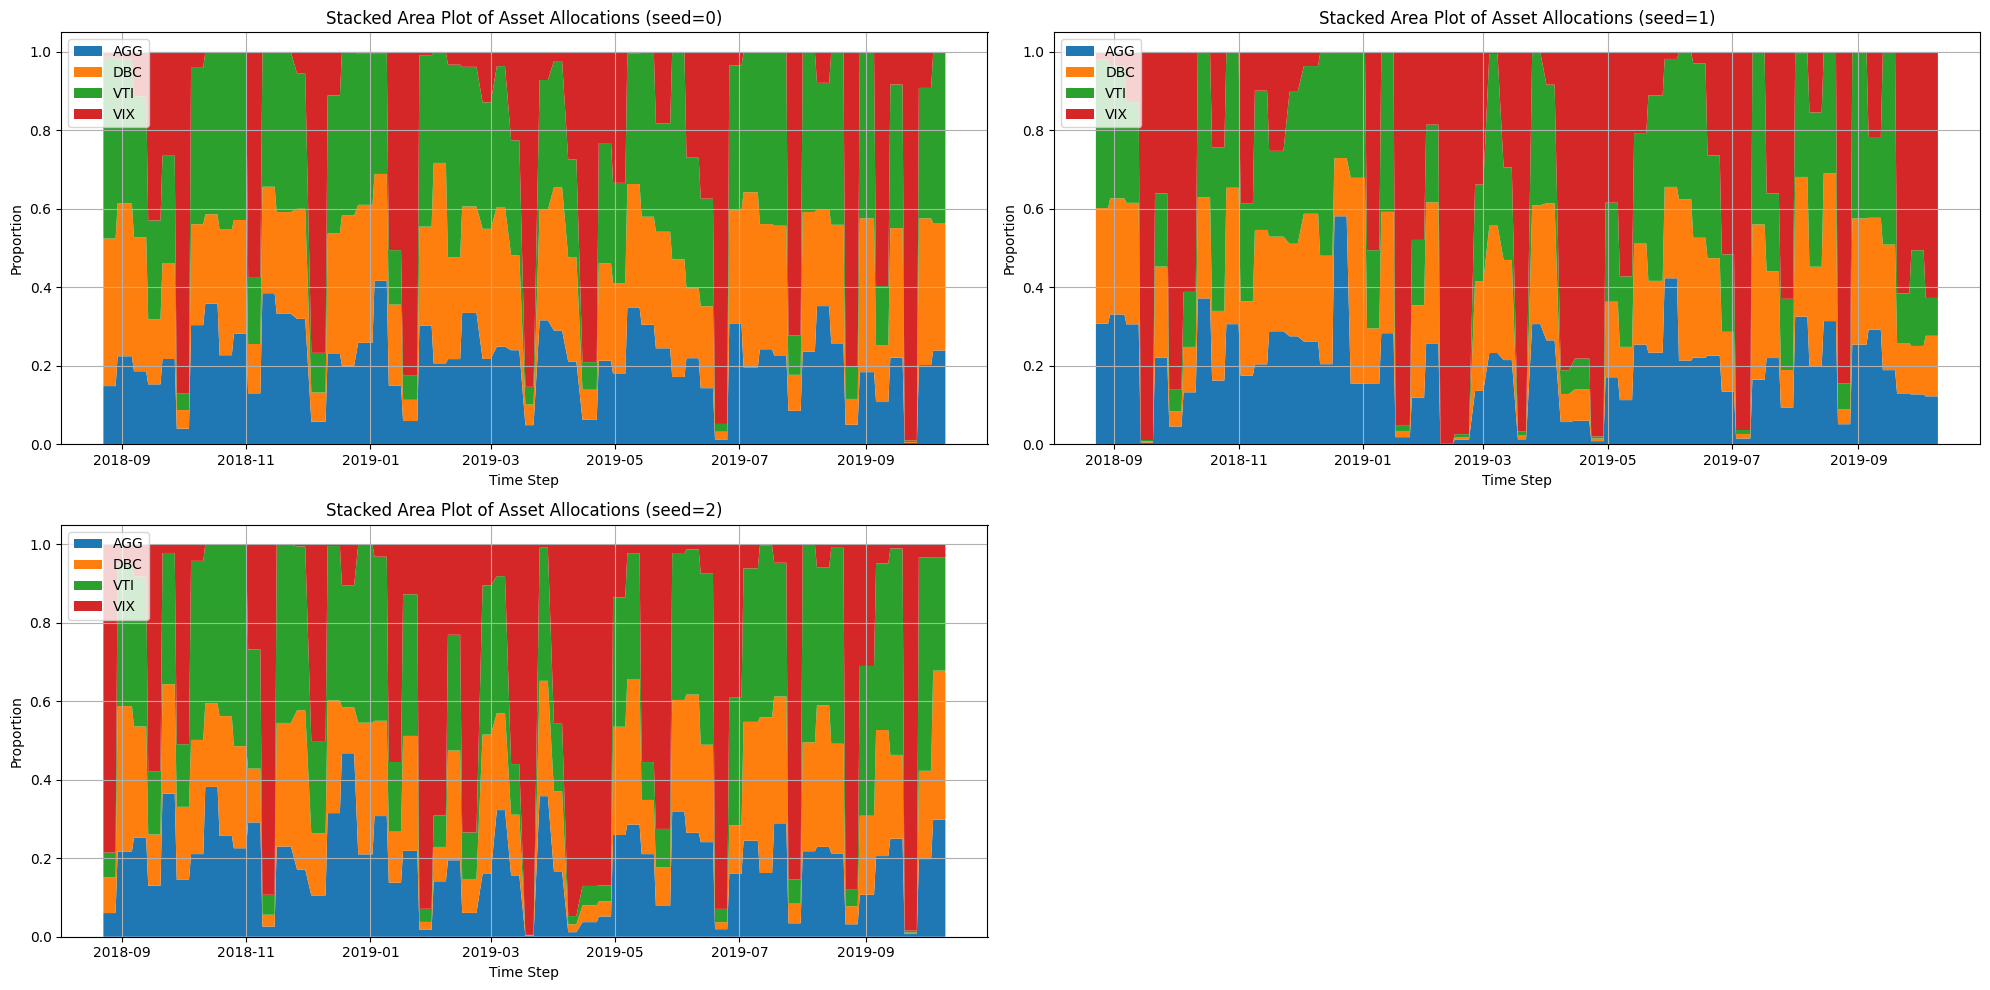

In [460]:
filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk]) for pk in params])}
display_train_results(filtered_experiements)
for dataset_key, dataset_idx in zip(["test", "val"], [test_idx, val_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(filtered_experiements, dataset_key, dataset_idx )

## Comparison of models

{'seed': 0, 'epochs': 30, 'lambda_entropy': 0.01, 'model': 'MLP', 'learning_rate': 0.001, 'checkpoint_freq': 3, 'rebalance_freq': 5}
Loading fyp3/experiments/standard_model/seed=0,epochs=30,lambda_entropy=0.01,model=MLP,learning_rate=0.001,checkpoint_freq=3,rebalance_freq=5,checkpoint=15.pth
{'seed': 0, 'epochs': 30, 'lambda_entropy': 0.0025, 'model': 'CNN', 'learning_rate': 0.001, 'checkpoint_freq': 10, 'rebalance_freq': 5}
Loading fyp3/experiments/standard_model/seed=0,epochs=30,lambda_entropy=0.0025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=10.pth
{'seed': 0, 'epochs': 100, 'lambda_entropy': 0.025, 'model': 'LSTM', 'lstm_layers': 4, 'lstm_hidden_layers': 1, 'learning_rate': 0.001, 'rebalance_freq': 5, 'checkpoint_freq': 8}
Loading fyp3/experiments/standard_model/seed=0,epochs=100,lambda_entropy=0.025,model=LSTM,lstm_layers=4,lstm_hidden_layers=1,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=8,checkpoint=40.pth
{'seed': 0, 'epochs': 20, 'lamb

/tmp/ipykernel_395219/1706481994.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


expected_return sharpe_ratio max_drawdown mean_entropy  \
MLP                    2.24       0.0542        0.475        0.718   
CNN                    1.78         0.05        0.523        0.279   
LSTM                   6.94       0.0864        0.333         1.15   
Transformer            2.47       0.0608        0.314         1.01   

            mean_return std_return  
MLP             0.00272     0.0502  
CNN             0.00238     0.0476  
LSTM            0.00364     0.0421  
Transformer     0.00234     0.0386

(752,)
(752,)
(752,)
(752,)


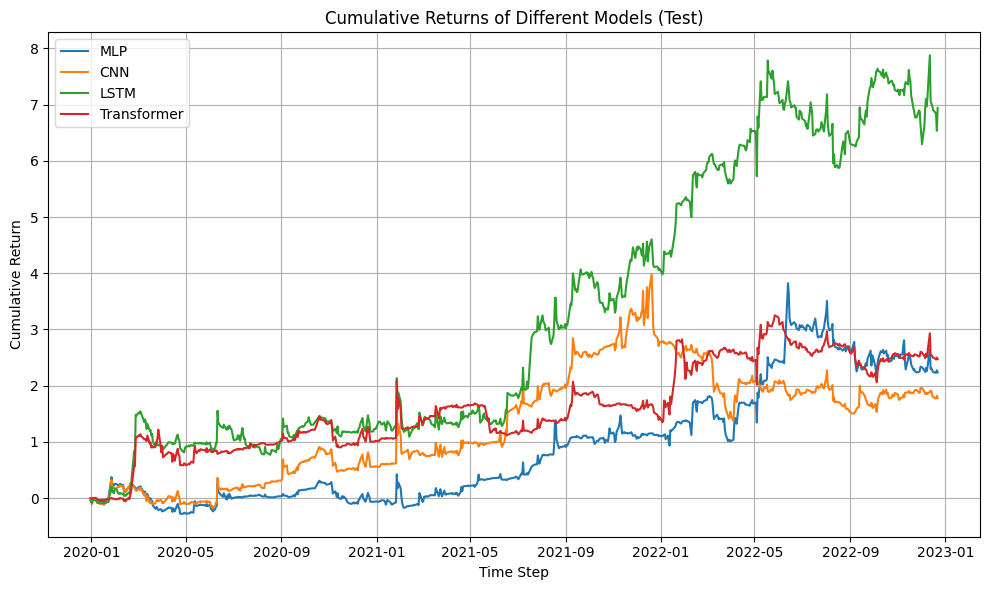

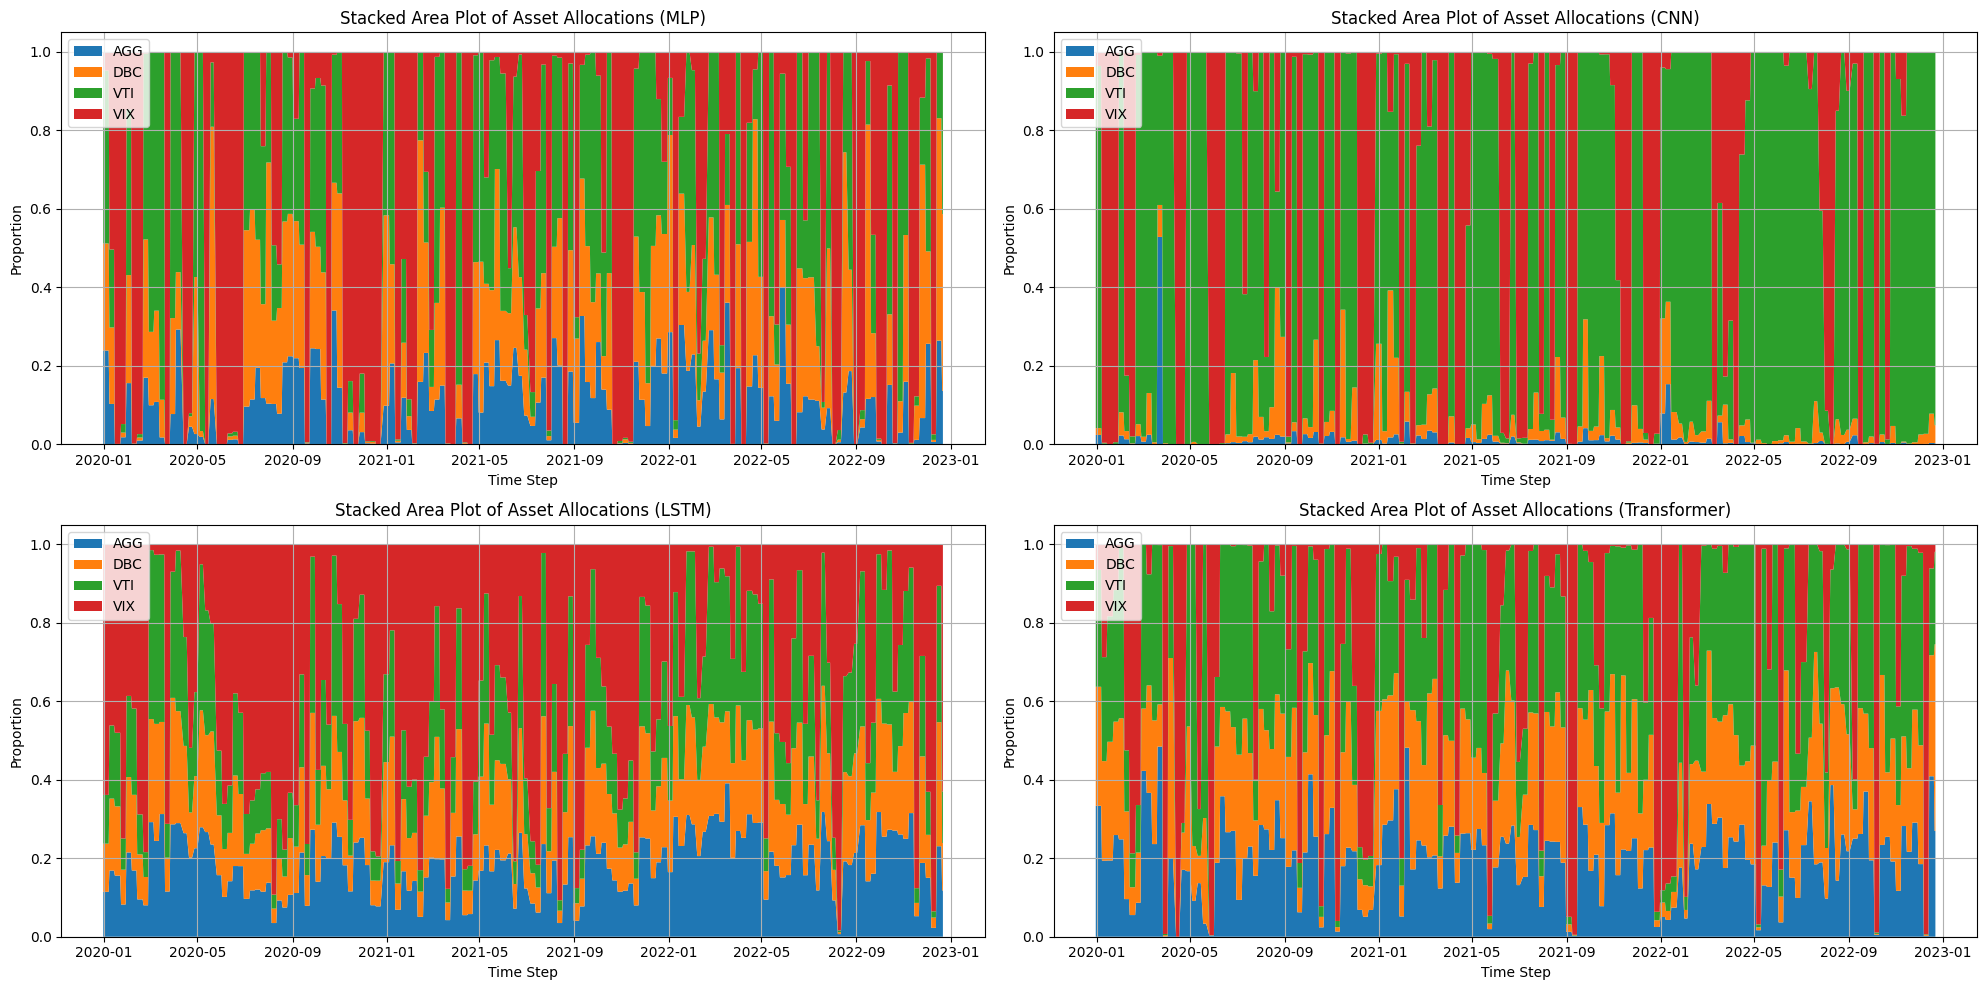

--------------------
Val RESULTS
--------------------


/tmp/ipykernel_395219/1706481994.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


expected_return sharpe_ratio max_drawdown mean_entropy  \
MLP                    2.87        0.115        0.347        0.772   
CNN                   0.568       0.0566         0.31         0.31   
LSTM                  0.584       0.0624        0.259         1.13   
Transformer            1.55        0.121        0.191         1.09   

            mean_return std_return  
MLP             0.00601     0.0524  
CNN             0.00236     0.0417  
LSTM            0.00218      0.035  
Transformer     0.00376     0.0311

(285,)
(285,)
(285,)
(285,)


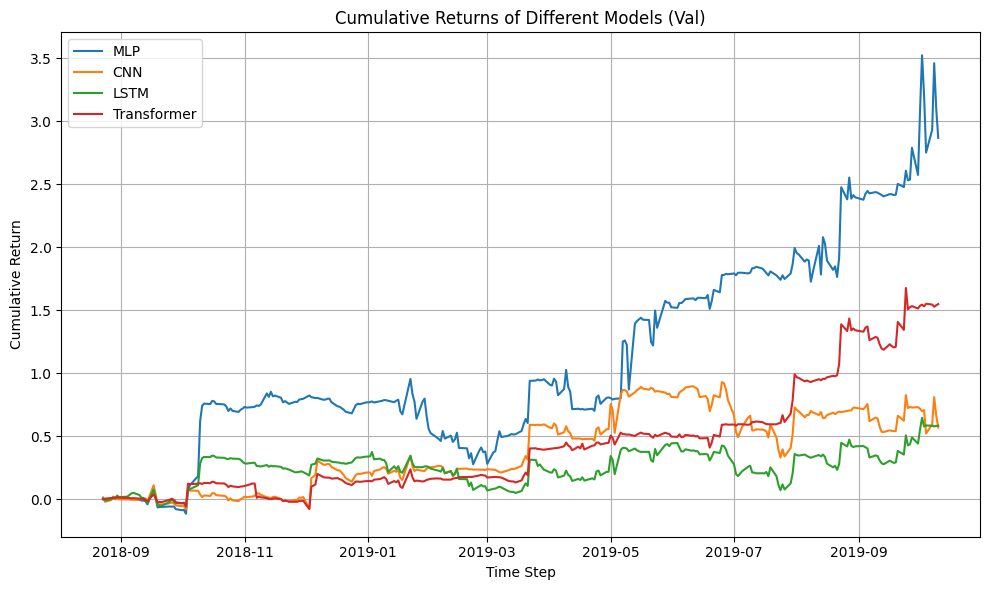

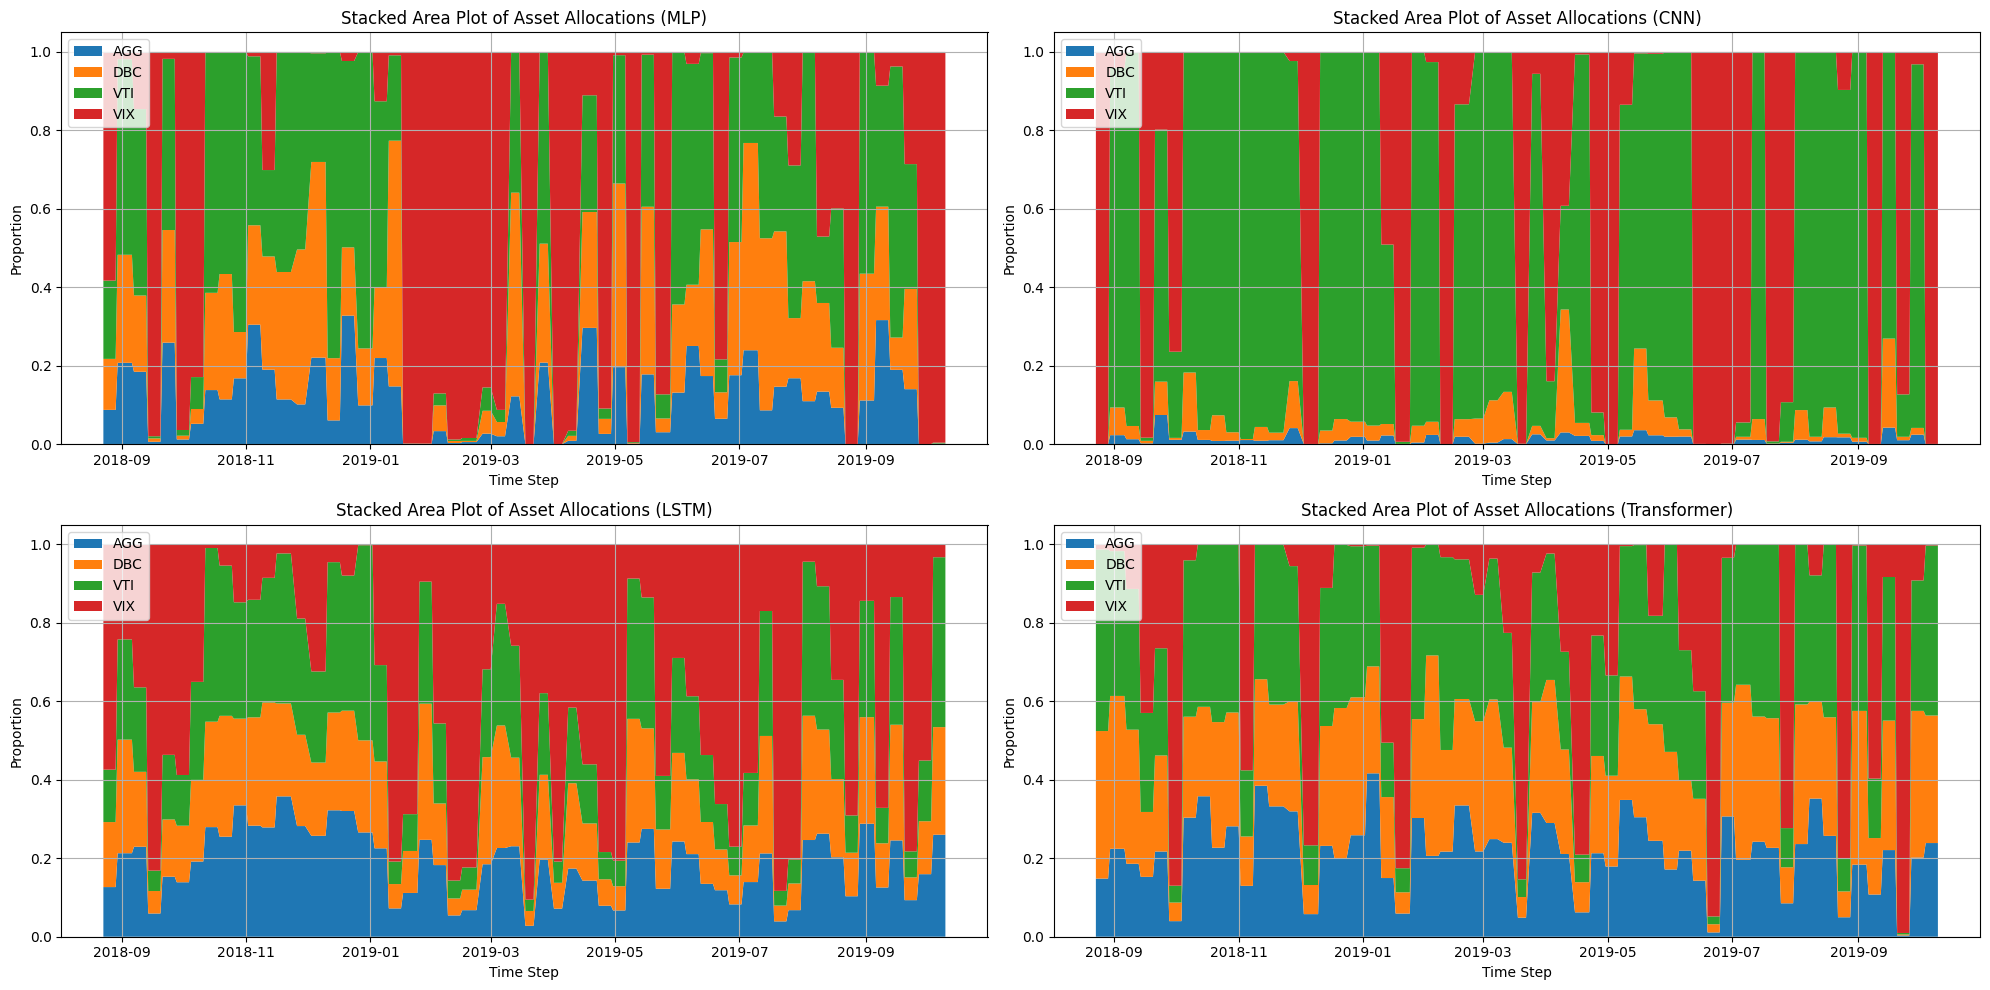

In [465]:
params_grids = [{"seed": [0]} | {k: [v] for k,v in ps.items()} for ps in [best_MLP_params, best_CNN_params, best_lstm_params, best_transformer_params]]

experiment_path = "fyp3/experiments/standard_model/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)

# display_train_results(experiments)

def custom_label_from_params(params, _):
    if params["model"] == "Transformer":
        return "Transformer"
    return params["model"].upper()

for dataset_key, dataset_idx in zip(["test", "val"], [test_idx, val_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx, label_from_params=custom_label_from_params)

In [ ]:
# def loss_fn_fn(params):
#     lambda_entropy = params["lambda_entropy"]
#     def loss_fn(x, y, model):
#         weights = model(x)

#         asset_returns = ((1 + y).prod(1)-1)
#         portfolio_returns = (asset_returns*weights).sum(1)
#         natural_loss = -portfolio_returns.mean() 
#         clamped_weights = weights.clamp(min=1e-8)
#         entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())
#         return natural_loss -  entropy_loss
#     return loss_fn 
    
# def model_fn(params):
#     if params["model"] == "CNN":
#         model = CNNAllocatorCausal(4, lookback, dropout_rate=params["dropout"]).to(device)
#     else:
#         model = SimpleAssetAllocationModel(4*lookback)

#     return model

# params_grids = [{
#     "seed": [0],
#     "epochs": [10, 20, 30],
#     "lambda_entropy": [1e-4, 1e-3, 1e-2, 0.05, 0.1],
#     "model": ["CNN"],
#     "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
# },
# ]

# experiment_path = "fyp3/experiments/standard_model/"
# experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)
# experiments["Uniform Baseline"] = {"model": UniformModel(), "params": {"label": "Uniform Baseline"}, "results": {}}

# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

# display_train_results(experiments)
# for dataset_key, dataset_idx in zip(["test", "val", "train",], [test_idx, val_idx, train_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(experiments, dataset_key, dataset_idx )

Training 


Epochs:   0%|                                            | 0/10 [00:00<?, ?ep/s]

Epochs: 100%|█████| 10/10 [00:04<00:00,  2.05ep/s, train_loss=nan, val_loss=nan]


Saving seed=0,epochs=10,lambda_entropy=0.0001,model=CNN,dropout=0.1,learning_rate=0.001,rebalance_freq=5,checkpoint=10.pth
Training 


Epochs: 100%|█| 10/10 [00:04<00:00,  2.31ep/s, train_loss=-0.04652, val_loss=-0.


Saving seed=0,epochs=10,lambda_entropy=0.001,model=CNN,dropout=0.1,learning_rate=0.001,rebalance_freq=5,checkpoint=10.pth
Training lambda_entropy=0.01


Epochs: 100%|█| 10/10 [00:04<00:00,  2.07ep/s, train_loss=-0.05807, val_loss=-0.


Saving seed=0,epochs=10,lambda_entropy=0.01,model=CNN,dropout=0.1,learning_rate=0.001,rebalance_freq=5,checkpoint=10.pth
Training lambda_entropy=0.05


Epochs:  30%|▎| 3/10 [00:01<00:04,  1.56ep/s, train_loss=-0.08152, val_loss=-0.0


KeyboardInterrupt: 

In [ ]:

def loss_fn_fn(params):
    lambda_risk = 1.5
    lambda_entropy = params["lambda_entropy"]


    def loss_fn(x, y, model):
        weights_ = model(x)
        
        weights = weights_.unsqueeze(1).repeat(1, horizon, 1)

        portfolio_returns = (weights * y).sum(1).sum(1)

        natural_loss = -portfolio_returns.mean() 

        clamped_weights = weights.clamp(min=1e-8)
        entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

        return natural_loss -  entropy_loss
    return loss_fn
    

def model_fn(params):
    if params["model"] == "CNN":
        model = CNNAllocatorCausal(4, lookback, dropout_rate=params["dropout"]).to(device)
    else:
        model = SimpleAssetAllocationModel(4*lookback)

    return model

params_grids = [{
    "seed": [441],
    "epochs": [10],
    "lambda_entropy": [1e-4, 1e-3, 1e-2, 0.05, 0.1, 0.5, 1.0],
    # "lambda_entropy": [0.0],
    "model": ["CNN"],
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
},
]

experiment_path = "fyp3/experiments/standard_model/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)
experiments["Uniform Baseline"] = {"model": UniformModel(), "params": {"label": "Uniform Baseline"}, "results": {}}


for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx )

In [ ]:
params_grids = [{
    "seed": [441,2,3],
    "epochs": [10, 20, 30],
    "lambda_entropy": [1e-2],
    "model": ["CNN"],
    "dropout": [0.1, 0],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
},
]

experiment_path = "fyp2/experiments/standard_model/"

experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)
experiments["Uniform Baseline"] = {"model": UniformModel(), "params": {"label": "Uniform Baseline"}, "results": {}}


for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx )

## Param tuning - robust eps alpha first

In [ ]:
from auto_LiRPA import BoundedTensor, PerturbationLpNorm,BoundedModule

In [ ]:
e = returns_df.loc[train_indices].std()
e = (e / e["VTI"]).to_numpy()

In [ ]:
# def pgd_attack(model, x_init, y, eps, loss_fn=nn.MSELoss(), n_steps=20, step_size=0.1, device='cuda:0'):
#     model.eval()

#     x_init = x_init.to(device)
#     y = y.to(device)
#     if torch.is_tensor(eps):
#         eps = eps.to(device)

#     attack_point = x_init.clone().detach()
#     attack_loss = torch.full((x_init.size(0),), -float('inf'), device=device)
#     adv_input = x_init.clone().detach().requires_grad_(True)

#     for _ in range(n_steps):
#         if adv_input.grad is not None:
#             adv_input.grad.zero_()

#         adv_outs = model(adv_input)
#         obj = -loss_fn(adv_outs, y)

#         mask = (obj >= attack_loss).view((-1,) + (1,) * (x_init.dim() - 1))
#         attack_point = torch.where(mask, adv_input.detach().clone(), attack_point)
#         attack_loss = torch.where(obj >= attack_loss, obj.detach(), attack_loss)

#         grad = torch.autograd.grad(obj.sum(), adv_input)[0]
#         adv_input = (adv_input + step_size * grad.sign()).clamp(x_init - eps, x_init + eps).detach().requires_grad_(True)

#     adv_outs = model(adv_input)
#     obj = -loss_fn(adv_outs, y)
#     mask = (obj >= attack_loss).view((-1,) + (1,) * (x_init.dim() - 1))
#     attack_point = torch.where(mask, adv_input.detach().clone(), attack_point)

#     return attack_point


def pgd_attack(model, x_init, y, eps, loss_fn, n_steps=20, step_size=0.1, device='cuda:0'):
    # 0/0
    model.eval()
    x0 = x_init.to(device)
    y0 = y.to(device)
    eps = eps.to(device) if torch.is_tensor(eps) else eps

    # start from the clean example, one tensor that always requires grad
    adv = x0.clone().detach().requires_grad_(True)
    best_loss = torch.full((x0.size(0),), -float('inf'), device=device)
    with torch.enable_grad():
        for _ in range(n_steps):
            # zero the gradient from the previous step
            if adv.grad is not None:
                adv.grad.zero_()
            # forward + objective (we do -loss because we want the *worst* point)
            logits = model(adv)
            obj = -loss_fn(logits, y0)            # this must be a Tensor, not a float

            # keep the best‐so‐far point per example
            mask = (obj >= best_loss).view(-1, *([1] * (adv.dim()-1)))
            best_loss = torch.where(obj >= best_loss, obj.detach(), best_loss)
            # you can store best‐so‐far inputs if needed, same pattern

            # compute gradient w.r.t. adv
            obj.sum().backward()                  # builds d(obj)/d(adv)
            # PGD step: modify adv.data in‐place, then clamp
            adv.data = (adv.data + step_size * adv.grad.data.sign())
            adv.data = adv.data.clamp(x0 - eps, x0 + eps)

    # at the end, adv contains your adversarial examples
    return adv.detach()



def robust_loss_fn_fn(params):
    if params["loss"] == "Standard":
        lambda_entropy = params["lambda_entropy"]
    
        def loss_fn(x, y, model):
            weights = model(x)


            asset_returns = ((1 + y).prod(1)-1)

            portfolio_returns = (asset_returns*weights).sum(1)

            natural_loss = -portfolio_returns.mean() 

            clamped_weights = weights.clamp(min=1e-8)
            entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

            return natural_loss -  entropy_loss
        return loss_fn 
    elif params["loss"] == "CROWN-IBP" or params["loss"] == "IBP":
        lambda_entropy = params["lambda_entropy"]
        alpha = params["alpha"]
        robust_eps = params["robust_eps"]
        eps_vector = torch.tensor(e*robust_eps, dtype=torch.float32, device=device)
        

        def loss_fn(x, y, model):
            weights = model(x)

            eps_tensor =eps_vector.repeat(x.shape[0], 50, 1)
            perturbation = PerturbationLpNorm(norm=np.inf, eps=eps_tensor)
            x_perturbed = BoundedTensor(x, perturbation)
            ub, lb = model.compute_bounds(x=(x_perturbed,), method=params["loss"])

            asset_returns = ((1 + y).prod(1)-1)

            portfolio_returns = (asset_returns*weights).sum(1)
            worst_returns = torch.min(asset_returns * ub, asset_returns * lb).sum(1)

            natural_loss = -portfolio_returns.mean() 
            robust_loss = -worst_returns.mean() 

            clamped_weights = weights.clamp(min=1e-8)
            entropy_loss = -lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

            return natural_loss * (1-alpha) + robust_loss * alpha + entropy_loss
        return loss_fn
    
    elif params["loss"] in ["MTL-IBP", "Exp-IBP", "CC-IBP"]:
        lambda_entropy = params["lambda_entropy"]
        alpha = params["alpha"]
        robust_eps = params["robust_eps"]
        eps = e*robust_eps
        eps_vector = torch.tensor(eps, dtype=torch.float32, device=device)
        def pgd_attack_loss(x, y):
            loss = ((1 + y).prod(1) * x).sum(1)
            return loss
        def loss_fn(x, y, model):
            model.eval()
            output_adv = model(pgd_attack(model, x, y, eps_vector, pgd_attack_loss, n_steps=10))
            model.train()
            
            eps_tensor =eps_vector.repeat(x.shape[0], 50, 1)
            perturbation = PerturbationLpNorm(norm=np.inf, eps=eps_tensor)
            x_perturbed = BoundedTensor(x, perturbation)
            ub, lb = model.compute_bounds(x=(x_perturbed,), method="IBP")
            asset_returns = ((1 + y).prod(1)-1)

            weights = model(x)
            clamped_weights = weights.clamp(min=1e-8)
            entropy_loss = -lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

            if params["loss"] == "CC-IBP":
                returns = torch.min(asset_returns * (output_adv * alpha + ub * (1-alpha)), asset_returns * (output_adv * alpha + lb * (1-alpha))).sum(1)
                loss = returns.mean()

                return loss + entropy_loss

            else:
                worst_returns = torch.min(asset_returns * ub, asset_returns * lb).sum(1)
                robust_loss = -worst_returns.mean() 
                output_adv
                adv_returns = (output_adv * asset_returns).sum(1)
                adv_loss = -adv_returns.mean() 

                if params["loss"] == "MTL-IBP":
                    loss = (adv_loss *(1 - alpha)) + (robust_loss * alpha) + entropy_loss
                elif params["loss"] == "Exp-IBP":
                    loss = (adv_loss **(1 - alpha)) + (robust_loss ** alpha) + entropy_loss

                return loss
        return loss_fn
      
    raise NotImplementedError(f"Not implemented loss {params['loss']}")

In [ ]:
   
# def model_fn(params):
#     if params["model"] == "CNN":
#         model = CNNAllocatorCausal(4, lookback, dropout_rate=params["dropout"]).to(device)
#         bound_opts = {
#             "optimize_bound_args": {
#                 "enable_alpha_crown": True,   # α-CROWN
#                 "enable_beta_crown": True,    # β-CROWN (branch-and-bound)
#                 "optimizer": "adam",          
#                 "iteration": 5,              # α/β optimization steps
#                 "lr_alpha": 0.5,
#                 "lr_beta": 0.05,
#                 "pruning_in_iteration": True
#             },
#             "verbose":True,
#             "conv_mode": "matrix"
#         }
#         model = BoundedModule(model, X_train_tensor.to(device), bound_opts=bound_opts).to(device)
#     elif params["model"] == "Uniform":
#         model = UniformModel() 
#         model = BoundedModule(model, X_train_tensor).to(device)
#     else:
#         model = SimpleAssetAllocationModel(4*lookback) 
#         model = BoundedModule(model, X_train_tensor).to(device)
        
#     return model

# params_grids = [{
#     "seed": [2],
#     "epochs": [5],
#     "model": ["MLP"],
#     "loss": ["CROWN-IBP"],
#     "alpha": [0,0.01, 0.1],
#     "robust_eps": [0.01, 0.001, 0.05, 0.0001],
#     "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "lambda_entropy": [0.01]
# },
# ]

# experiment_path = "fypv3/experiments/standard_model/"
# experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
# experiments["Uniform Baseline"] = {"model": UniformModel(), "params": {"label": "Uniform Baseline"}, "results": {}}


# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

# display_train_results(experiments)
# for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(experiments, dataset_key, dataset_idx )

## Param tuning - robust eps & alpha

In [ ]:
# params_grids = [{
#     "seed": [2],
#     "epochs": [10],
#     "model": ["MLP"],
#     "alpha": [0.01, 0.1, 0.2, 0.3, 0.5, 0.75, 1],
#     "robust_eps": [0.0001, 0.0005],
#     "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "loss": ["Standard"],
#     "lambda_entropy": [0.01]
# },
# ]

# experiment_path = "fyp/experiments/standard_model/"
# experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
# experiments["Uniform Baseline"] = {"model": UniformModel(), "params": {"label": "Uniform Baseline"}, "results": {}}


# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

# display_train_results(experiments)
# for dataset_key, dataset_idx in zip(["test"], [test_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     metrics_df = display_experiment_results(experiments, dataset_key, dataset_idx )

In [ ]:
# metrics_df  = pd.DataFrame({label_from_params(v["params"], experiments): v['results']["test"]["metrics"] | v["params"] for k, v in experiments.items()}).T

# to_plot = metrics_df[metrics_df["robust_eps"] == 0.0005]

# plt.figure()
# # plt.plot(to_plot["alpha"], to_plot["shape"], label="Sharpe")
# plt.plot(to_plot["alpha"], to_plot["max_drawdown"], label="MD")
# plt.plot(to_plot["alpha"], to_plot["mean_entropy"], label="Entropy")
# plt.legend()
# plt.show()

# to_plot = metrics_df[metrics_df["robust_eps"] == 0.0005]

# plt.figure()
# plt.plot(to_plot["alpha"], to_plot["mean_return"], label="MR")
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(to_plot["alpha"], to_plot["std_return"], label="MR")
# plt.legend()
# plt.show()
# to_plot

## Final check sharpe

# Robust Analysis

In [ ]:
def model_fn(params):
    if params["model"] == "CNN":
        model = CNNAllocatorCausal(4, lookback, dropout_rate=params["dropout"])
        bound_opts = {
            "optimize_bound_args": {
                "enable_alpha_crown": True,   # α-CROWN
                "enable_beta_crown": True,    # β-CROWN (branch-and-bound)
                "optimizer": "adam",          
                "iteration": 5,              # α/β optimization steps
                "lr_alpha": 0.5,
                "lr_beta": 0.05,
                "pruning_in_iteration": True
            },
            "verbose":True,
            "conv_mode": "matrix"
        }
        model = BoundedModule(model.to(device), X_train_tensor.to(device), bound_opts=bound_opts).to(device)

    else:
        model = SimpleAssetAllocationModel(4*lookback) 
        model = BoundedModule(model, X_train_tensor).to(device)
        
    return model


params_grids = [{
    "seed": [0],
    "epochs": [10, 20],
    "model": ["CNN"],
    "alpha": [0.5],
    "robust_eps": [0.0005],
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "loss": ["CROWN-IBP"],
    "lambda_entropy": [0.025]
},
{
    "seed": [0],
    "epochs": [10],
    "model": ["CNN"],
    "alpha": [0],
    "robust_eps": [0.0000],
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "loss": ["Standard"],
    "lambda_entropy": [0.025]
},
]

experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx )

In [ ]:
def bound_model(model, x, eps, method, batch_size=1):
    upper_batches = []
    lower_batches = []
    x = x.to(device)
    N = x.shape[0]

    if method == "CROWN-Optimized":
        model.get_split_nodes()

    out_shape = (N, 4)

    for i in tqdm(range(0, N, batch_size)):
        x_batch = x[i: i+batch_size]
        eps_vector = torch.tensor(eps, dtype=torch.float32, device=device)  # One ε per asset
        eps_tensor = eps_vector.view(1, 1, -1).expand_as(x_batch) 

        perturbation = PerturbationLpNorm(norm=np.inf, eps=eps_tensor)
        x_perturbed = BoundedTensor(x_batch, perturbation)
        lb, ub = model.compute_bounds(x=(x_perturbed,), method=method)
        lower_batches.append(lb.to(device))
        upper_batches.append(ub.to(device))

    lb_out = torch.zeros(out_shape, device=device)
    ub_out = torch.ones(out_shape, device=device)

    lower_all = torch.cat(lower_batches, dim=0)
    upper_all = torch.cat(upper_batches, dim=0)

    lower_all = torch.max(lower_all, lb_out)
    upper_all = torch.min(upper_all, ub_out)

    return lower_all, upper_all

In [ ]:

def loss_fn(x, y):
    loss = ((1 + y).prod(1) * x).sum(1)
    return loss

In [ ]:
test_period = 20
test_eps = [1/100, 1/200]


In [ ]:
eps_tensor = torch.tensor(e, dtype=torch.float32, device=device)

In [ ]:
def bound_experiments(experiments, methods, x, test_eps):
    for model_name, experiment in experiments.items():
        model = experiment["model"]
        
        experiment["results"]["test"]["bounds"] = {}
        experiment["results"]["test"]["bounds"]["None"] = model(x)
        
        for method in methods:
            experiment["results"]["test"]["bounds"][method] = {}
            for eps in test_eps:
                print(f"{method} {eps}")
                experiment["results"]["test"]["bounds"][method][eps] = bound_model(model, x, eps_tensor * eps, method, batch_size=1)

In [ ]:
def pgd_attack_experiments(experiments, x, y, test_eps):
    for model_name, experiment in experiments.items():
        if "epochs" not in experiment["params"]:
            continue
        model = experiment["model"]

        experiment["results"]["test"]["PGD"] = {}
        experiment["results"]["test"]["PGD_AdvX"]  = {}
        experiment["results"]["test"]["PGD_AdvY"]  = {}
        for eps in test_eps:
            attack_point = pgd_attack(model, x, y, (eps * eps_tensor), loss_fn)
            experiment["results"]["test"]["PGD_AdvX"][eps] = attack_point
            experiment["results"]["test"]["PGD_AdvY"][eps] = model(attack_point)

In [ ]:
test_period = 10
test_eps = [1/200, 1/500, 1/1000]
x = X_test_tensor[::horizon].to(device)
y = y_test_tensor[::horizon].to(device)
pgd_attack_experiments(experiments, x, y, test_eps)

In [ ]:
bound_experiments(experiments, ["IBP", "CROWN"], x ,test_eps)

In [ ]:
def get_experiment_returns(experiments, y):
    for model_name, experiment in experiments.items():
        model = experiment["model"]

        model_weights = experiment["results"]["test"]["bounds"]["None"].to(device)
        returns = experiment["results"]["test"]["returns"] = {}
        asset_returns = (y+1).prod(1)-1

        returns["None"] = (asset_returns * model_weights).sum(1)

        for method in ["IBP", "CROWN"]:
            returns[method] = {}
            for eps, bounds in experiment["results"]["test"]["bounds"][method].items():
                ub, lb = bounds
                returns[method][eps] = torch.min(asset_returns * lb, asset_returns * ub).sum(1)

        if "epochs" not in experiment["params"]:
            continue

        returns["PGD"] = {}

        for eps, weights in experiment["results"]["test"]["PGD_AdvY"].items():
            returns["PGD"][eps] = (asset_returns * weights).sum(1)
            # print(returns["PGD"][eps])

In [ ]:
get_experiment_returns(experiments, y)

In [ ]:
# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     y = y_test_tensor[::5][:test_period]

#     model_weights = experiment["results"]["test"]["bounds"]["None"]
#     returns = experiment["results"]["test"]["returns"] = {}
#     asset_returns = (y+1).prod(1)-1

#     returns["None"] = (asset_returns * model_weights).sum(1)

#     for method in ["IBP", "CROWN"]:
#         returns[method] = {}
#         for eps, bounds in experiment["results"]["test"]["bounds"][method].items():
#             ub, lb = bounds
#             returns[method][eps] = torch.min(asset_returns * lb, asset_returns * ub).sum(1)

#     if "epochs" not in experiment["params"]:
#         continue

#     returns["PGD"] = {}

#     for eps, weights in experiment["results"]["test"]["PGD_AdvY"].items():
#         returns["PGD"][eps] = (asset_returns * weights).sum(1)
#         print(returns["PGD"][eps])
        

In [ ]:
def deltas_experiments(experiments):
    for model_name, experiment in experiments.items():
        returns = experiment["results"]["test"]["returns"] 
        deltas = experiment["results"]["test"]["deltas"] = {}
        model_returns = returns["None"]

        for method, return_dict in returns.items():
            if method == "None":
                continue
            deltas[method] = {}
            for eps, ret in return_dict.items():
                deltas[method][eps] = ((ret + 1) -(model_returns+1))/ (model_returns+1)  

deltas_experiments(experiments)

In [ ]:
model_names = list(experiments.keys())
model_names.remove("Uniform Baseline")
model_names

In [ ]:
experiments.keys()

experiments_to_display = {k: experiments[k] for k in experiments.keys() if k != "Uniform Baseline"}

In [ ]:

def box_plot_experiment(experiments, method):
    model_names = list(experiments.keys())
    first = experiments[model_names[0]]["results"]["test"]["deltas"][method]
    thresholds = sorted(first.keys())
    n_thresh = len(thresholds)
    model_labels = [label_from_params(experiments[m]["params"], experiments) for m in model_names]

    # prepare figure
    fig, ax = plt.subplots(figsize=(12,6))
    
    # width of each box, total span = width * n_models
    n_models = len(model_names)
    width = 0.8 / n_models
    ind = np.arange(n_thresh)
    
    # define a color cycle or list here if you like
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    # plot each model
    box_handles = []
    for i, model_name in enumerate(model_names):
        data = experiments[model_name]["results"]["test"]["deltas"][method]

        vals = [data[t].detach().cpu() for t in thresholds]
        
        pos = ind - 0.4 + width*(i + 0.5)
        b = ax.boxplot(
            vals,
            positions=pos,
            widths=width,
            patch_artist=True,
            boxprops=dict(facecolor=colors[i % len(colors)], alpha=0.6),
            medianprops=dict(color='black'),
            manage_ticks=False
        )
        # grab one of the boxes for the legend
        box_handles.append(b["boxes"][0])
    
    # labels & legend
    ax.set_xticks(ind)
    ax.set_xticklabels([str(t) for t in thresholds])
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Max change in returns')
    ax.set_title(f'Model Comparison at Different Thresholds ({method})')
    ax.legend(box_handles, model_labels, loc='upper left')
    
    plt.tight_layout()
    plt.show()

for method in ["IBP", "CROWN", "PGD"]:
    box_plot_experiment(experiments_to_display, method)

In [ ]:
def plot_experiment_delta_returns_vs_epsilon(experiments):
    model_names = list(experiments.keys())
    fig, ax = plt.subplots(figsize=(12, 6))
    first = experiments[model_names[0]]["results"]["test"]["deltas"]["CROWN"]
    thresholds = sorted(first.keys())
    model_labels = ["CROWN", "IBP", "PGD"]

    for i, (model_name, model_label) in enumerate(zip(model_names, model_labels)):
        crown_bounds = [torch.mean(experiments[model_name]["results"]["test"]["deltas"]["CROWN"][eps].cpu()) for eps in thresholds]
        IBP_bounds = [torch.mean(experiments[model_name]["results"]["test"]["deltas"]["IBP"][eps].cpu()) for eps in thresholds]

        # print(experiments[model_name]["results"]["test"]["deltas"]["PGD"].keys(), thresholds)
        PGD_bounds = [torch.mean(experiments[model_name]["results"]["test"]["deltas"]["PGD"][eps].cpu()) for eps in thresholds]
        plt.plot(thresholds, crown_bounds, color = colors(i), linestyle='-', label=f"{model_label} CROWN")
        plt.plot(thresholds, IBP_bounds, color = colors(i),  linestyle='dashdot', label=f"{model_label} IBP")
        plt.plot(thresholds, PGD_bounds, color = colors(i),  linestyle='dotted', alpha=0.7, label=f"{model_label} PGD")
    plt.xlabel('Epsilon')
    plt.legend()
    plt.ylabel('Delta Returns')
    plt.show()

plot_experiment_delta_returns_vs_epsilon(experiments_to_display)

In [ ]:
def plot_experiment_delta_returns_vs_time(experiments, model_labels, max_points=30):
    model_names = list(experiments.keys())
    first = experiments[model_names[0]]["results"]["test"]["deltas"]["CROWN"]
    thresholds = sorted(first.keys())

    for eps in thresholds:
        fig, ax = plt.subplots(figsize=(12, 6))
        #   model_labels = [label_from_params(experiments[m]["params"], experiments) for m in model_names]

        for i, (model_name, model_label) in enumerate(zip(model_names, model_labels)):
            #     print(model_label)
                data = experiments[model_name]["results"]["test"]["deltas"]["CROWN"][eps].cpu()[:max_points]
                
                ax.plot(data, '-', label=f'{model_label} Verified Bound', color = colors(i))

                data = experiments[model_name]["results"]["test"]["deltas"]["PGD"][eps].cpu()[:max_points]
                ax.plot(data, '--', label=f'{model_label} Adverserial Attack', alpha=0.5, color = colors(i))

        ax.set_xlabel('Date')
        ax.set_ylabel('Max change in returns')
        ax.set_title(f'Model Comparison Over Time {eps} {method}')
        ax.legend(loc='best')
        ax.grid(True)
        ax.set_yscale('symlog', linthresh=0.001, base=10)


        plt.tight_layout()
        plt.show()

plot_experiment_delta_returns_vs_time(experiments_to_display, ["Robust Model", "Standard Model"])

In [ ]:
# def plot attack ###
# for model_name in model_names:
#     first = experiments[model_names[0]]["results"]["test"]["deltas"]["PGD"]
#     thresholds = sorted(first.keys())
#     for eps in [0.002]:
#         deltas = experiments[model_name]["results"]["test"]["deltas"]["PGD"][eps]

#         min_idx = torch.argmin(deltas)


#         adv_X = experiments[model_name]["results"]["test"]["PGD_AdvX"][eps]
#         adv_Y = experiments[model_name]["results"]["test"]["PGD_AdvY"][eps]
#         deltas = experiments[model_name]["results"]["test"]["deltas"]["PGD"][eps]

#         model_weights = experiments[model_name]["results"]["test"]["bounds"]["None"]

#         data_np = X_test_tensor[::5][min_idx].numpy()
#         data_np2 = adv_X[min_idx].cpu().numpy()

#         time = range(data_np.shape[0])  # 0,1,…,49

#         # Create a 2×2 grid of subplots
#         fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)

#         # Flatten the axes array for easy iteration
#         axes = axes.flatten()

#         for i, ax in enumerate(axes):
#             ax.plot(time, data_np[:, i], marker='o', linestyle='-')
#             ax.plot(time, data_np2[:, i], marker='o', linestyle='-')
#             ax.set_title(f'{asset_names[i]}')
#             ax.set_ylabel('Value')
#             ax.grid(True, linestyle='--', alpha=0.5)

#         # Label the shared x-axis on the bottom row
#         for ax in axes[2:]:
#             ax.set_xlabel('Time')

#         fig.suptitle(f'Tensor Data over Time (2×2 Grid) {label_from_params(experiments[model_name]["params"], experiments)} {eps}', y=0.95)
#         plt.tight_layout()
#         plt.show()

# Robust Training

In [ ]:
from tqdm import tqdm

In [ ]:
standard_param_grid = [{
    "seed": [44, 1,2],
    "epochs": [10],
    "model": ["CNN"],
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["Standard"]
}]
robust_eps = [0.001, 0.0005, 0.0001, 0.00001, 0.00001, 0.00005, 0.000001]

In [ ]:
params_grids = standard_param_grid 

experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx)

In [ ]:
def linestyle_map(params):
    if "robust_eps" in params:
        return "-"
    else:
        return "--"

### IBP

In [ ]:
IBP_param_grid = [
{
    "seed": [3],
    "epochs": [10],
    "model": ["CNN"],
    "alpha": [0.5],
    "robust_eps": robust_eps,
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["IBP"],
}
]

params_grids = standard_param_grid + IBP_param_grid

experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx)

### CROWN-IBP

In [ ]:
robust_eps2 = [0.001, 0.0005, 0.0001, 0.00001, 0.00001, 0.000001]

CROWN_IBP_param_grid =[
{
    "seed": [3],
    "epochs": [10],
    "model": ["CNN"],
    "alpha": [0.5],
    "robust_eps": robust_eps2,
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["CROWN-IBP"],
}
]

params_grids = CROWN_IBP_param_grid

params_grids += [{
    "seed": [3],
    "epochs": [10],
    "model": ["CNN"],
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["Standard"]
}]


def labeler(params, _):
    if "robust_eps" in params:
        return f"Robust Model (train eps={params['robust_eps']})"
    elif "epochs" in params:
        return "Standard Model"
    else:
        return "Uniform Baseline"
    
experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    if dataset_key == "train":
        continue
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx, linestyle_map, labeler)

In [ ]:
test_eps = [0.001, 0.002, 0.003, 0.004, 0.005]
test_period = 100
x = X_test_tensor[::horizon].to(device)[:test_period]
y = y_test_tensor[::horizon].to(device)[:test_period]
pgd_attack_experiments(experiments, x, y, test_eps)
bound_experiments(experiments, ["IBP", "CROWN"], x ,test_eps)
get_experiment_returns(experiments, y)
deltas_experiments(experiments)

In [ ]:
len(experiments_to_display.keys())

In [ ]:
experiments_to_display = {k: experiments[k] for k in experiments.keys() if k != "Uniform Baseline"}

model_names = list(experiments_to_display.keys())
fig, ax = plt.subplots(figsize=(12, 8))
first = experiments_to_display[model_names[0]]["results"]["test"]["deltas"]["CROWN"]
thresholds = sorted(first.keys())

def labeler(params):
    if "robust_eps" in params:
        return f"Robust Model (train eps={params['robust_eps']})"
    elif "epochs" in params:
        return "Standard Model"
    else:
        return "Uniform Baseline"

model_labels = [labeler(exp["params"]) for exp in experiments_to_display.values()]

for i, (model_name, model_label) in enumerate(zip(model_names, model_labels)):
    crown_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["CROWN"][eps].cpu()) for eps in thresholds]
    IBP_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["IBP"][eps].cpu()) for eps in thresholds]

    PGD_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["PGD"][eps].cpu()) for eps in thresholds]
    plt.plot(thresholds, crown_bounds, color = colors(i), linestyle='-', label=f"{model_label} Verified Bound")
    plt.plot(thresholds, PGD_bounds, color = colors(i),  linestyle='dotted', alpha=0.7, label=f"{model_label} Worst PGD Attack")
plt.xlabel('Test Epsilon')
plt.legend()
plt.title("Mean Delta Returns By Test Epsilon (Test Data)")
plt.ylabel('Mean Delta Return')
plt.show()

In [ ]:
experiments_to_display = {k: experiments[k] for k in experiments.keys() if k != "Uniform Baseline"}

model_names = list(experiments_to_display.keys())
fig, ax = plt.subplots(figsize=(16, 10))
first = experiments_to_display[model_names[0]]["results"]["test"]["deltas"]["CROWN"]
thresholds = sorted(first.keys())

def labeler(params):
    if "robust_eps" in params:
        return f"Robust Model (train eps={params['robust_eps']})"
    else:
        return "Standard Model"

model_labels = [labeler(exp["params"]) for exp in experiments_to_display.values()]

for i, (model_name, model_label) in enumerate(zip(model_names, model_labels)):

    # print([experiments_to_display[model_name]["results"]["test"]["metrics"].keys() for eps in thresholds])
    crown_bounds = [experiments_to_display[model_name]["results"]["test"]["metrics"]["expected_return"] for eps in thresholds]
    # IBP_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["IBP"][eps].cpu()) for eps in thresholds]

    # PGD_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["PGD"][eps].cpu()) for eps in thresholds]
    plt.plot(thresholds, crown_bounds, color = colors(i), linestyle='-', label=f"{model_label} Verified Bound")
    # plt.plot(thresholds, PGD_bounds, color = colors(i),  linestyle='dotted', alpha=0.7, label=f"{model_label} Worst PGD Attack")
plt.xlabel('Test Epsilon')
plt.legend()
plt.ylabel('Maximum Delta Returns')
plt.show()

### MLT-IBP

In [ ]:
MTL_IBP_param_grids = [
    {
    "seed": [3],
    "epochs": [10],
    "model": ["CNN"],
    "alpha": [0.25, 0.5, 0.75],
    "robust_eps": robust_eps,
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["MTL-IBP"],
}
]

params_grids = standard_param_grid + MTL_IBP_param_grids

experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx)

### CC-IBP

In [ ]:
# CC_IBP_param_grids = [
#     {
#     "seed": [3],
#     "epochs": [10],
#     "model": ["CNN"],
#     "alpha": [0.05],#[0, 0.25, 0.5, 0.75, 1],
#     "robust_eps": [0.00001],#[0.00001, 0.000005],
#     "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "lambda_entropy": [0.025],
#     "loss": ["CC-IBP"],
# }
# ]

# params_grids = standard_param_grid + CC_IBP_param_grids

# experiment_path = "fyp3/experiments/robust_models2/"
# experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
# experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

# display_train_results(experiments)
# for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(experiments, dataset_key, dataset_idx)

## Model Comparison

In [ ]:
params_grids = standard_param_grid + IBP_param_grid + CROWN_IBP_param_grid + MTL_IBP_param_grids

experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

In [ ]:
for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)


In [ ]:
# test_period = 10
test_eps = [1/500]
x = X_test_tensor[::horizon].to(device)[:test_period]
y = y_test_tensor[::horizon].to(device)[:test_period]
pgd_attack_experiments(experiments, x, y, test_eps)
bound_experiments(experiments, ["IBP", "CROWN"], x ,test_eps)
get_experiment_returns(experiments, y)
deltas_experiments(experiments)

In [ ]:
filtered_experiements = [
    # {k: experiments[k] for k in experiments.keys() if "loss" in experiments[k]["params"] and experiments[k]["params"]["loss"] == "Standard"},
    {k: experiments[k] for k in experiments.keys() if "loss" in experiments[k]["params"] and experiments[k]["params"]["loss"] == "IBP"},
    {k: experiments[k] for k in experiments.keys() if "loss" in experiments[k]["params"] and experiments[k]["params"]["loss"] == "CROWN-IBP"}   
]

for alpha in [0.25, 0.5, 0.75]:
    filtered_experiements.append({k: experiments[k] for k in experiments.keys() if "loss" in experiments[k]["params"] and experiments[k]["params"]["loss"] == "MTL-IBP" and experiments[k]["params"]["alpha"] == alpha})

model_names = ["IBP", "CROWN-IBP", "MTL-IBP α=0.25", "MTL-IBP α=0.5", "MTL-IBP α=0.75"]

In [ ]:
for metric in ["mean_return", "shape", "max_drawdown", "mean_entropy"]:
    plt.figure()
    for name, fs in zip(model_names, filtered_experiements):
        eps = [exp["params"]["robust_eps"] for exp in fs.values()]
        e_return = [exp["results"]["test"]["metrics"][metric] for exp in fs.values()]
        pairs = sorted(zip(eps, e_return), key=lambda x: x[0])
        eps, e_return =  zip(*pairs)
        plt.plot(eps, e_return, label = name)
    plt.title(metric)
    plt.xlabel("Train ε")
    plt.ylabel("Mean Test Return")
    plt.legend()
    plt.show()

In [ ]:
for metric in ["CROWN", "PGD"]:
    models = ["CROWN-IBP", "IBP"]
    plt.figure()
    for name, fs in zip(model_names, filtered_experiements):
        eps = [exp["params"]["robust_eps"] for exp in fs.values()]

        e_return = [torch.mean(exp["results"]["test"]["deltas"]["CROWN"][0.002].cpu()) for exp in fs.values()]#[exp["results"]["test"]["metrics"][metric] for exp in filtered_experiements.values()]
        pairs = sorted(zip(eps, e_return), key=lambda x: x[0])
        eps, e_return =  zip(*pairs)
        plt.plot(eps, e_return, label = name)
    plt.title(metric)
    plt.xlabel("Train ε")
    plt.ylabel("Worst Return")
    plt.legend()
    plt.show()

In [ ]:
# As train eps increaes, how does it affect the expected returns under CROWN?
# As train-eps increase, how does it affect the deltas
# Treat each alpha sepererately for the blended pgd-ibp
# Then is that MVP done?

# Email updates !!!
# Draft email
# Datasets
# Loss functions
# Standard model
# Checking Robustness 
# Comparision of models

